In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

import os, sys
import torch
from torch import nn

if IN_COLAB:
  !pip install imageio-ffmpeg
import imageio
from IPython.display import HTML
from base64 import b64encode
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2024-02-20 13:07:01--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2024-02-20 13:07:01--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M   392KB/s    in 32s     

2024-02-20 13:07:32 (394 KB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


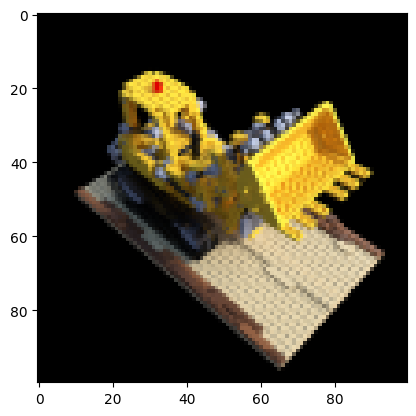

In [3]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

In [4]:
def embed_fn(x, L_embed=6):
    rets = [x]
    for i in range(L_embed):
        for fn in [torch.sin, torch.cos]:
            rets.append(fn(2.**i * x))
    return torch.cat(rets, -1).to(device)


class NeRF(nn.Module):
    def __init__(self, useViewDirs=False, D=8, W=256, skip=[4], pos_embed=10, view_embed=4):
        super(NeRF, self).__init__()
        self.useViewDirs = useViewDirs
        inputSize = 3 + 3*2*pos_embed
        d_viewdirs = 3 + 3*2*view_embed
        self.inputLayer = nn.Linear(inputSize, W)
        self.hiddenLayers = nn.ModuleList()
        for i in range(D-1):
            if i in skip:
                self.hiddenLayers.append(nn.Linear(W+inputSize, W))
            else:
                self.hiddenLayers.append(nn.Linear(W, W))

        if useViewDirs:
            self.alpha_out = nn.Linear(W, 1)
            self.rgb_filters = nn.Linear(W, W)
            self.branch = nn.Linear(W + d_viewdirs, W // 2)
            self.output = nn.Linear(W // 2, 3)
        else:
            self.outputLayer = nn.Linear(W, 4)
        self.skip = skip

    def forward(self, x, viewdirs=None):
        x_initial = x
        x = nn.functional.relu(self.inputLayer(x))
        for i, layer in enumerate(self.hiddenLayers):
            x = nn.functional.relu(layer(x))
            if i+1 in self.skip:
                x = torch.cat([x, x_initial], dim=-1)

        if self.useViewDirs:
            alpha = self.alpha_out(x)

            x = self.rgb_filters(x)
            x = torch.concat([x, viewdirs], dim=-1)
            x = nn.functional.relu(self.branch(x))
            x = self.output(x)

            x = torch.concat([x, alpha], dim=-1)
        else:
            x=self.outputLayer(x)
        return x

def sample_pdf(bins, weights, N_samples, det=False):

    # Get pdf
    weights += 1e-5  # prevent nans
    pdf = weights / torch.sum(weights, -1, keepdims=True)
    cdf = torch.cumsum(pdf, dim=-1)
    cdf = torch.cat([torch.zeros_like(cdf[..., :1]), cdf], -1)

    # Take uniform samples if det=False
    if det:
        u = torch.linspace(0., 1., N_samples, device=cdf.device)
        u = torch.broadcast_to(u, list(cdf.shape[:-1]) + [N_samples])
    else:
        u = torch.rand(list(cdf.shape[:-1]) + [N_samples], device=cdf.device)

    # Invert CDF
    u = u.contiguous() #otherwise torch.searchsorted is not happy
    inds = torch.searchsorted(cdf, u, right=True)
    below = torch.clamp(inds - 1, min=0)
    above = torch.clamp(inds, max=cdf.shape[-1]-1)
    inds_g = torch.stack([below, above], dim=-1)
    shape = list(inds_g.shape[:-1]) + [cdf.shape[-1]]
    cdf_g = torch.gather(cdf.unsqueeze(-2).expand(shape), dim=-1, index=inds_g)
    bins_g = torch.gather(bins.unsqueeze(-2).expand(shape), dim=-1, index=inds_g)

    denom = (cdf_g[..., 1] - cdf_g[..., 0])
    denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom)
    t = (u - cdf_g[..., 0]) / denom
    samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

    return samples


In [5]:
# class full_NeRF(nn.Module):
#     def __init__(self, near: float, far: float, useViewDirs=True, useHierarchicalSampling=True, pos_embed=10, view_embed=4, chunksize=2**15, rand_stratified_sampling=True, D_coarse=8, D_fine=8, skip_coarse=[4], skip_fine=[4], W_coarse=256, W_fine=258):
#         super().__init__()
#         self.near = near
#         self.far = far
#         self.useViewDirs = useViewDirs
#         self.useHierarchicalSampling = useHierarchicalSampling
#         self.rand_stratified_sampling = rand_stratified_sampling
#         self.pos_embed = pos_embed
#         self.view_embed = view_embed if useViewDirs else None;
#         self.chunksize = chunksize
#         self.coarse_model = NeRF(useViewDirs=useViewDirs, D=D_coarse, W=W_coarse, skip=skip_coarse, pos_embed=pos_embed, view_embed=view_embed)
#         self.fine_model = NeRF(useViewDirs=useViewDirs, D=D_fine, W=W_fine, skip=skip_fine, pos_embed=pos_embed, view_embed=view_embed) if useHierarchicalSampling else None;

#     def make_chunks_pos(self, points):
#         points = points.reshape((-1, 3))
#         points = embed_fn(points, L_embed=self.pos_embed)
#         return [points[i:i + self.chunksize] for i in range(0, points.shape[0], self.chunksize)]

#     def make_chunks_view(self, points, rays_d):
#         viewdirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
#         viewdirs = viewdirs[:, None, ...].expand(points.shape).reshape((-1, 3))
#         viewdirs = embed_fn(viewdirs, L_embed=self.view_embed)
#         return [viewdirs[i:i + self.chunksize] for i in range(0, viewdirs.shape[0], self.chunksize)]

#     def render_rays(self, raw, z_vals, rays_d):
#         # Compute opacities and colors
#         sigma_a = nn.functional.relu(raw[...,3])
#         rgb = torch.sigmoid(raw[...,:3])

#         # Do volume rendering
#         dists = z_vals[..., 1:] - z_vals[..., :-1]
#         dists = torch.cat([dists, torch.full(dists[..., :1].shape, 1e10, device=device)], dim=-1)
#         dists = dists * torch.norm(rays_d[..., None, :], dim=-1)
#         alpha = 1.-torch.exp(-sigma_a * dists)
#         weights = torch.cumprod(1.-alpha + 1e-10, -1)
#         weights = torch.roll(weights, 1, -1)
#         weights[..., 0] = 1.
#         weights =  alpha * weights

#         rgb_map = torch.sum(weights[...,None] * rgb, -2)
#         return rgb_map, weights

#     def forward(self, rays_o: torch.Tensor, rays_d: torch.Tensor):
#         #Stratified sampling
#         z_vals = torch.linspace(self.near, self.far, N_samples, device=device)
#         z_vals = torch.broadcast_to(z_vals,list(rays_o.shape[:-1]) + [N_samples]).clone()
#         if self.rand_stratified_sampling:
#             z_vals += torch.rand(list(rays_o.shape[:-1]) + [N_samples], device=device) * (self.far-self.near)/N_samples
#         pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

#         chunks_pos = self.make_chunks_pos(pts)
#         if self.useViewDirs:
#             chunks_view = self.make_chunks_view(pts, rays_d)

#         #coarse model pass
#         predictions = []

#         if self.useViewDirs:
#             for chunk_pos, chunk_view in zip(chunks_pos, chunks_view):
#                 predictions.append(self.coarse_model(chunk_pos, chunk_view))

#         else:
#             for chunk_pos in chunks_pos:
#                   predictions.append(self.coarse_model(chunk_pos))

#         raw = torch.cat(predictions, dim=0)
#         raw = raw.reshape(list(pts.shape[:2]) + [raw.shape[-1]])

#         rgb_map, weights = self.render_rays(raw, z_vals, rays_d)

#         if not self.useHierarchicalSampling:
#             del weights
#         return rgb_map

#         #Hierarchical sampling

#         # Obtain additional integration times to evaluate based on the weights
#         # assigned to colors in the coarse model.
#         z_vals_mid = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
#         z_samples = sample_pdf(z_vals_mid, weights[..., 1:-1], N_samples_hierarchical, det=True)
#         z_samples = z_samples.detach() #equivalent to tf.stop_gradient(z_samples)

#         # Obtain all points to evaluate color, density at.
#         z_vals_combined, _ = torch.sort(torch.cat([z_vals, z_samples], dim=-1), dim=-1)
#         pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals_combined[..., :, None]  # [N_rays, N_samples + N_samples_hierarchical, 3]

#         del rgb_map, weights

#         chunks_pos = self.make_chunks_pos(pts)
#         if self.useViewDirs:
#             chunks_view = self.make_chunks_view(pts, rays_d)

#         #fine model pass
#         predictions = []
#         if self.useViewDirs:
#             for chunk_pos, chunk_view in zip(chunks_pos, chunks_view):
#                 predictions.append(self.fine_model(chunk_pos, chunk_view))
#         else:
#             for chunk_pos in chunks_pos:
#                 predictions.append(self.fine_model(chunk_pos))

#         raw = torch.cat(predictions, dim=0)
#         raw = raw.reshape(list(pts.shape[:2]) + [raw.shape[-1]])

#         rgb_map, _ = self.render_rays(raw, z_vals_combined, rays_d)

#         return rgb_map



# def get_rays(H, W, focal, c2w):
#     c2w = torch.from_numpy(c2w).to(device)
#     focal = torch.from_numpy(focal).to(device)
#     i, j = torch.meshgrid(torch.arange(W, dtype=torch.float32, device=device), torch.arange(H, dtype=torch.float32, device=device), indexing="xy")
#     dirs = torch.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -torch.ones_like(i)], -1)
#     rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
#     rays_o = torch.broadcast_to(c2w[:3,-1], rays_d.size())
#     return rays_o, rays_d



In [6]:

def gaussian_density(x, mu, sigma):
    exponent = -0.5 * ((x - mu) / sigma) ** 2
    return torch.exp(exponent) / (sigma * np.sqrt(2 * np.pi))

class full_NeRF(nn.Module):
    def __init__(self, near: float, far: float, useViewDirs=True, useHierarchicalSampling=True, pos_embed=10, view_embed=4, chunksize=2**15, rand_stratified_sampling=True, D_coarse=8, D_fine=8, skip_coarse=[4], skip_fine=[4], W_coarse=256, W_fine=258):
        super().__init__()
        self.near = near
        self.far = far
        self.useViewDirs = useViewDirs
        self.useHierarchicalSampling = useHierarchicalSampling
        self.rand_stratified_sampling = rand_stratified_sampling
        self.pos_embed = pos_embed
        self.view_embed = view_embed if useViewDirs else None;
        self.chunksize = chunksize
        self.coarse_model = NeRF(useViewDirs=useViewDirs, D=D_coarse, W=W_coarse, skip=skip_coarse, pos_embed=pos_embed, view_embed=view_embed)
        self.fine_model = NeRF(useViewDirs=useViewDirs, D=D_fine, W=W_fine, skip=skip_fine, pos_embed=pos_embed, view_embed=view_embed) if useHierarchicalSampling else None;

    def make_chunks_pos(self, points):
        points = points.reshape((-1, 3))
        points = embed_fn(points, L_embed=self.pos_embed)
        return [points[i:i + self.chunksize] for i in range(0, points.shape[0], self.chunksize)]

    def make_chunks_view(self, points, rays_d):
        viewdirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
        viewdirs = viewdirs[:, None, ...].expand(points.shape).reshape((-1, 3))
        viewdirs = embed_fn(viewdirs, L_embed=self.view_embed)
        return [viewdirs[i:i + self.chunksize] for i in range(0, viewdirs.shape[0], self.chunksize)]

    def render_rays(self, raw, z_vals, rays_d):
        # Compute opacities and colors
        sigma_a = nn.functional.relu(raw[..., 3])
        rgb = torch.sigmoid(raw[..., :3])

        # Compute density using a Gaussian function
        density = gaussian_density(sigma_a, mu=0.0, sigma=1.0)

        # Do volume rendering
        dists = z_vals[..., 1:] - z_vals[..., :-1]
        dists = torch.cat([dists, torch.full(dists[..., :1].shape, 1e10, device=device)], dim=-1)
        dists = dists * torch.norm(rays_d[..., None, :], dim=-1)
        alpha = 1. - torch.exp(-density * dists)
        weights = torch.cumprod(1. - alpha + 1e-10, -1)
        weights = torch.roll(weights, 1, -1)
        weights[..., 0] = 1.
        weights = alpha * weights

        rgb_map = torch.sum(weights[..., None] * rgb, -2)
        return rgb_map, weights
    #Hierarchical sampling

        # Obtain additional integration times to evaluate based on the weights
        # assigned to colors in the coarse model.
        z_vals_mid = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
        z_samples = sample_pdf(z_vals_mid, weights[..., 1:-1], N_samples_hierarchical, det=True)
        z_samples = z_samples.detach() #equivalent to tf.stop_gradient(z_samples)

        # Obtain all points to evaluate color, density at.
        z_vals_combined, _ = torch.sort(torch.cat([z_vals, z_samples], dim=-1), dim=-1)
        pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals_combined[..., :, None]  # [N_rays, N_samples + N_samples_hierarchical, 3]

        del rgb_map, weights

        chunks_pos = self.make_chunks_pos(pts)
        if self.useViewDirs:
            chunks_view = self.make_chunks_view(pts, rays_d)

        #fine model pass
        predictions = []
        if self.useViewDirs:
            for chunk_pos, chunk_view in zip(chunks_pos, chunks_view):
                predictions.append(self.fine_model(chunk_pos, chunk_view))
        else:
            for chunk_pos in chunks_pos:
                predictions.append(self.fine_model(chunk_pos))

        raw = torch.cat(predictions, dim=0)
        raw = raw.reshape(list(pts.shape[:2]) + [raw.shape[-1]])

        rgb_map, _ = self.render_rays(raw, z_vals_combined, rays_d)

        return rgb_map

    # def forward(self, rays_o: torch.Tensor, rays_d: torch.Tensor):
    #     # Stratified sampling
    #     z_vals = torch.linspace(self.near, self.far, N_samples, device=device)
    #     z_vals = torch.broadcast_to(z_vals, list(rays_o.shape[:-1]) + [N_samples]).clone()
    #     if self.rand_stratified_sampling:
    #         z_vals += torch.rand(list(rays_o.shape[:-1]) + [N_samples], device=device) * (self.far - self.near) / N_samples
    #     pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]

    #     chunks_pos = self.make_chunks_pos(pts)
    #     if self.useViewDirs:
    #         chunks_view = self.make_chunks_view(pts, rays_d)

    #     # Coarse model pass
    #     predictions = []

    #     if self.useViewDirs:
    #         for chunk_pos, chunk_view in zip(chunks_pos, chunks_view):
    #             predictions.append(self.coarse_model(chunk_pos, chunk_view))

    #     else:
    #         for chunk_pos in chunks_pos:
    #               predictions.append(self.coarse_model(chunk_pos))

    #     raw = torch.cat(predictions, dim=0)
    #     raw = raw.reshape(list(pts.shape[:2]) + [raw.shape[-1]])

    def forward(self, rays_o: torch.Tensor, rays_d: torch.Tensor):
        #Stratified sampling
        z_vals = torch.linspace(self.near, self.far, N_samples, device=device)
        z_vals = torch.broadcast_to(z_vals,list(rays_o.shape[:-1]) + [N_samples]).clone()
        if self.rand_stratified_sampling:
            z_vals += torch.rand(list(rays_o.shape[:-1]) + [N_samples], device=device) * (self.far-self.near)/N_samples
        pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

        chunks_pos = self.make_chunks_pos(pts)
        if self.useViewDirs:
            chunks_view = self.make_chunks_view(pts, rays_d)

        #coarse model pass
        predictions = []

        if self.useViewDirs:
            for chunk_pos, chunk_view in zip(chunks_pos, chunks_view):
                predictions.append(self.coarse_model(chunk_pos, chunk_view))

        else:
            for chunk_pos in chunks_pos:
                  predictions.append(self.coarse_model(chunk_pos))

        raw = torch.cat(predictions, dim=0)
        raw = raw.reshape(list(pts.shape[:2]) + [raw.shape[-1]])

        rgb_map, weights = self.render_rays(raw, z_vals, rays_d)

        if not self.useHierarchicalSampling:
            del weights
        return rgb_map


def get_rays(H, W, focal, c2w):
    c2w = torch.from_numpy(c2w).to(device)
    focal = torch.from_numpy(focal).to(device)
    i, j = torch.meshgrid(torch.arange(W, dtype=torch.float32, device=device), torch.arange(H, dtype=torch.float32, device=device), indexing="xy")
    dirs = torch.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -torch.ones_like(i)], -1)
    rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = torch.broadcast_to(c2w[:3,-1], rays_d.size())
    return rays_o, rays_d

Training model
0 0.04744160652160644 secs per iter


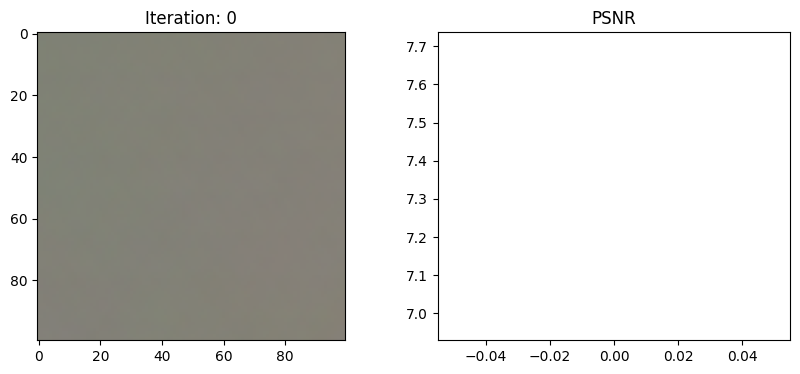

25 0.05037892341613769 secs per iter


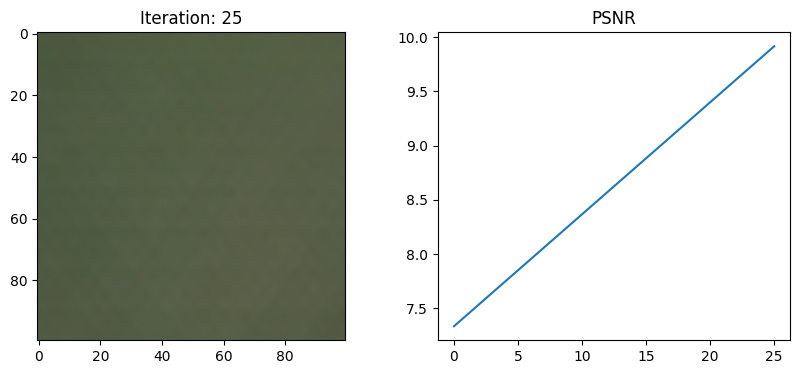

50 0.05908383369445801 secs per iter


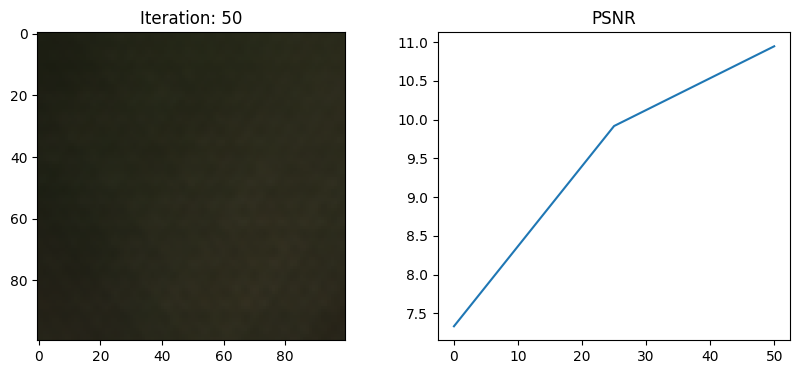

75 0.07712826728820801 secs per iter


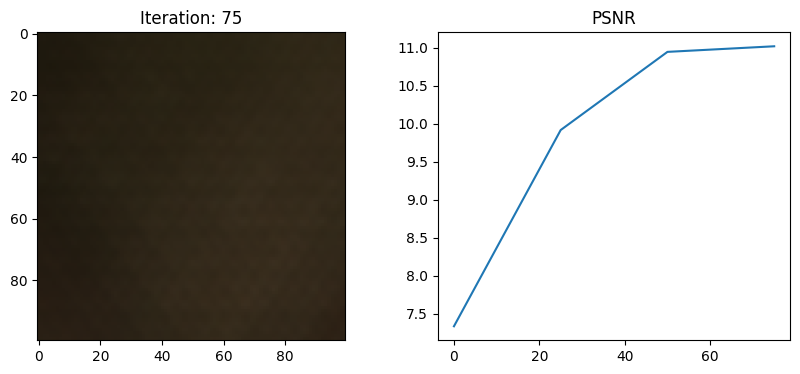

100 0.0594050121307373 secs per iter


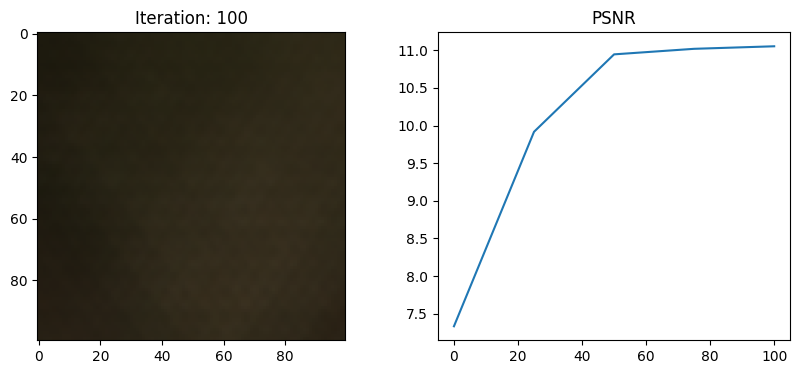

125 0.0621279239654541 secs per iter


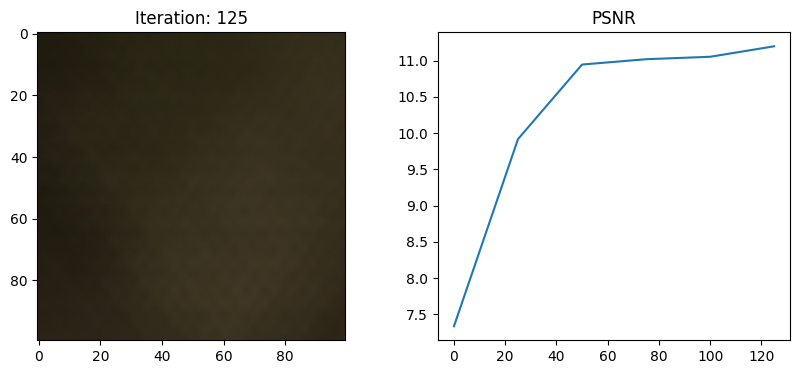

150 0.06156249046325683 secs per iter


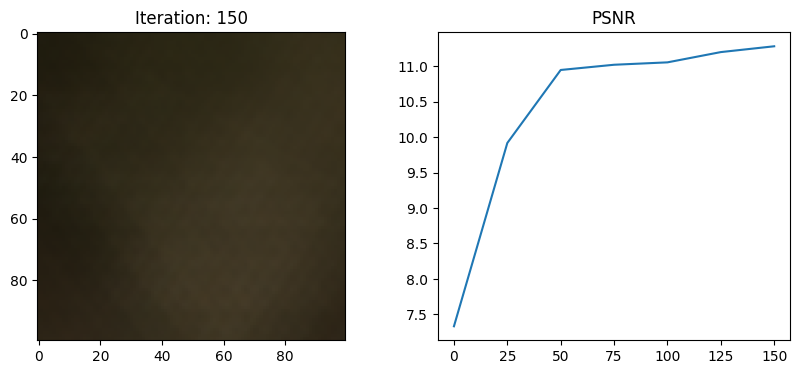

175 0.06522636413574219 secs per iter


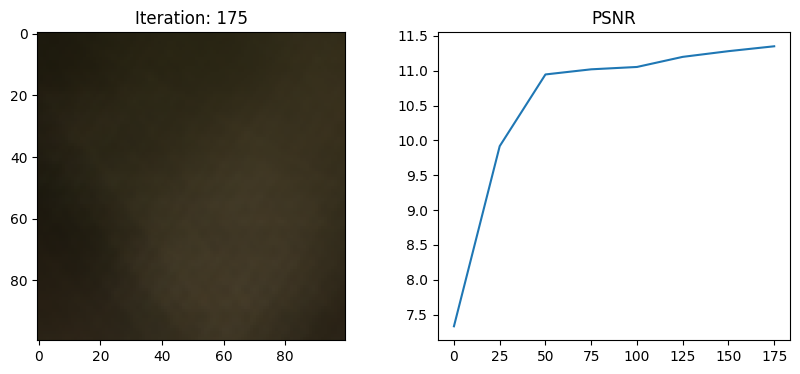

200 0.09004485130310058 secs per iter


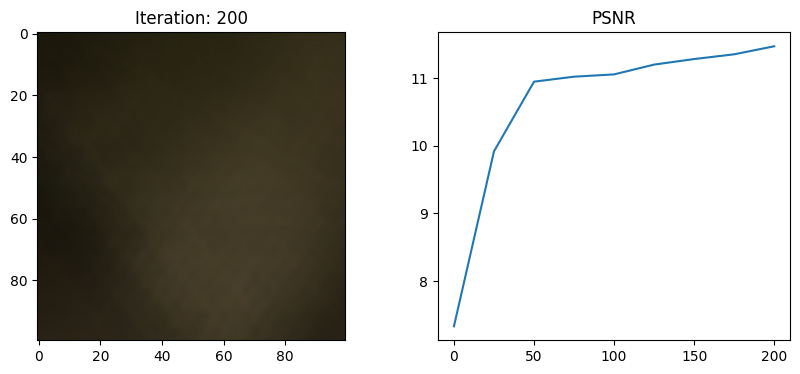

225 0.06463362693786621 secs per iter


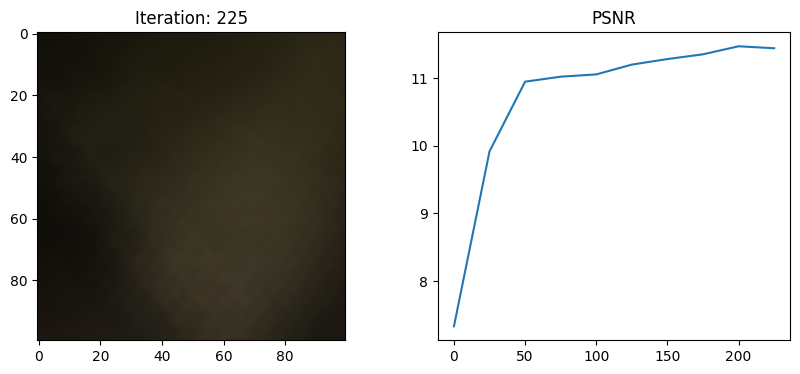

250 0.08213315963745117 secs per iter


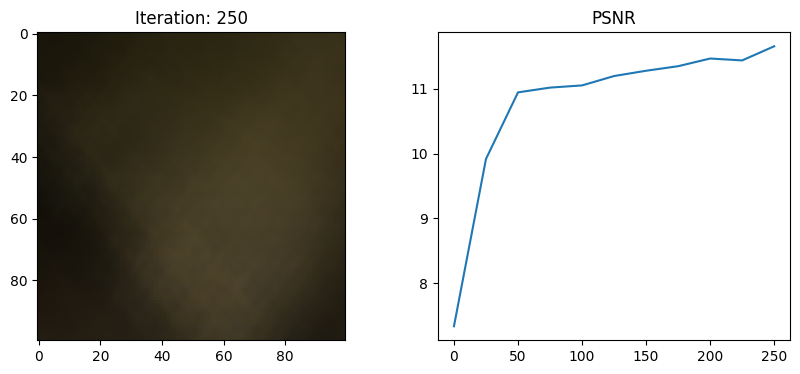

275 0.058891191482543945 secs per iter


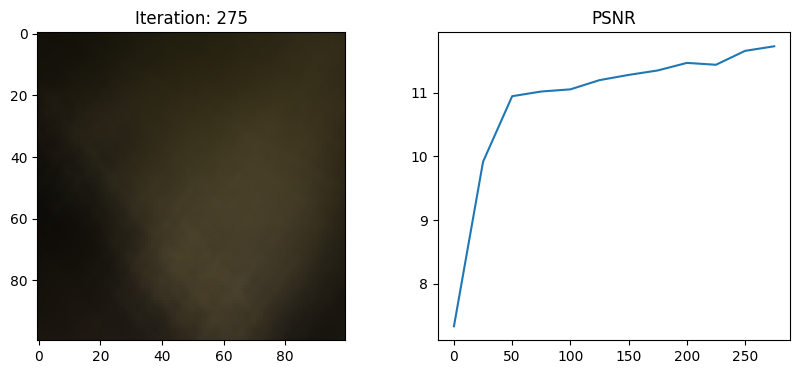

300 0.060885772705078126 secs per iter


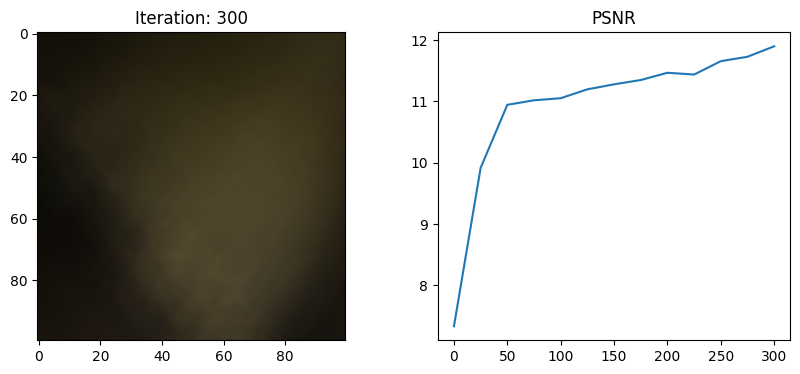

325 0.04948966979980469 secs per iter


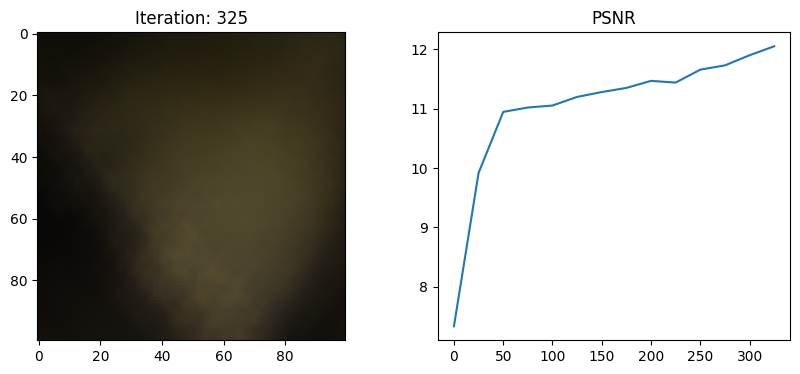

350 0.04898530006408691 secs per iter


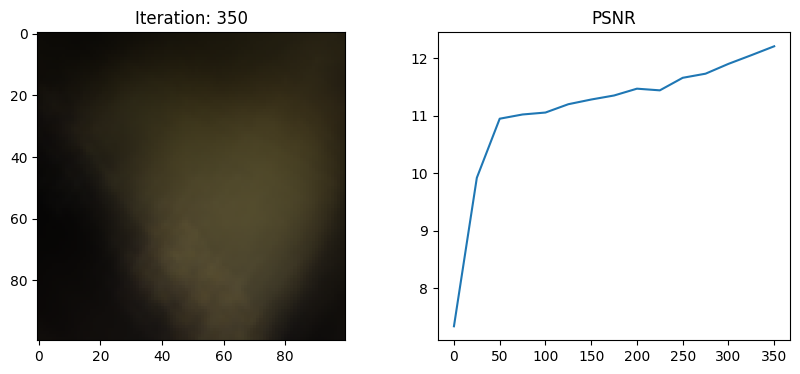

375 0.0487714672088623 secs per iter


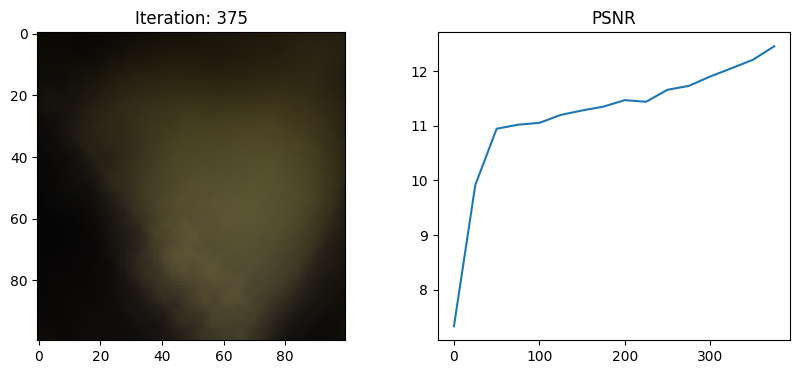

400 0.048167181015014646 secs per iter


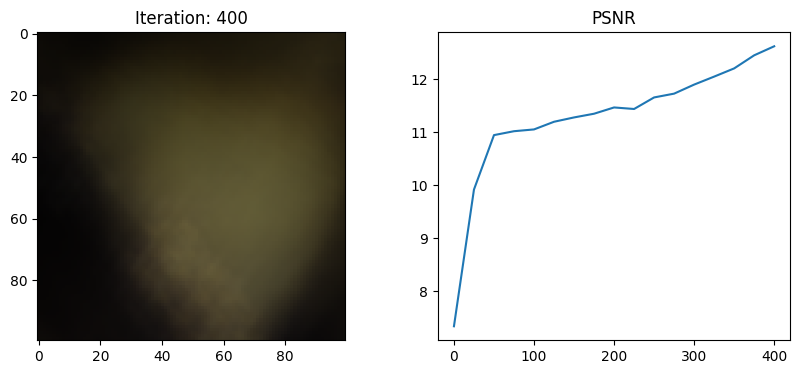

425 0.04830793380737305 secs per iter


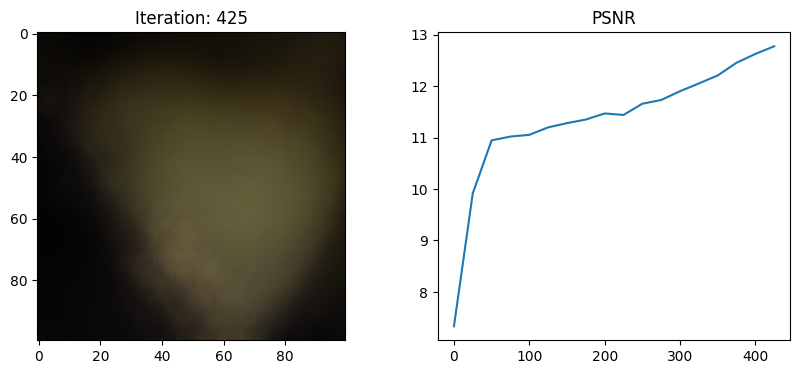

450 0.05085818290710449 secs per iter


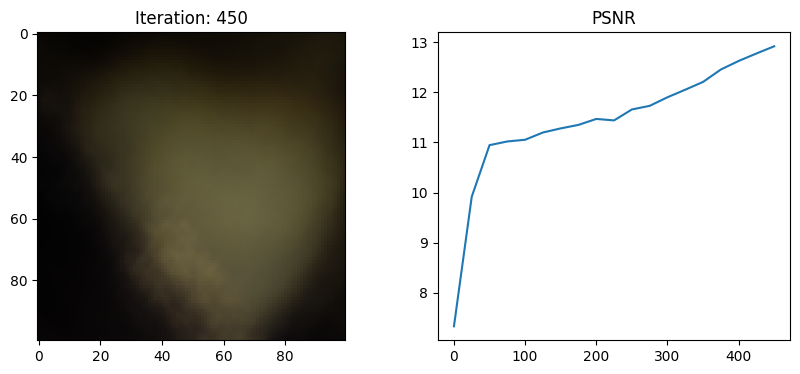

475 0.054908008575439454 secs per iter


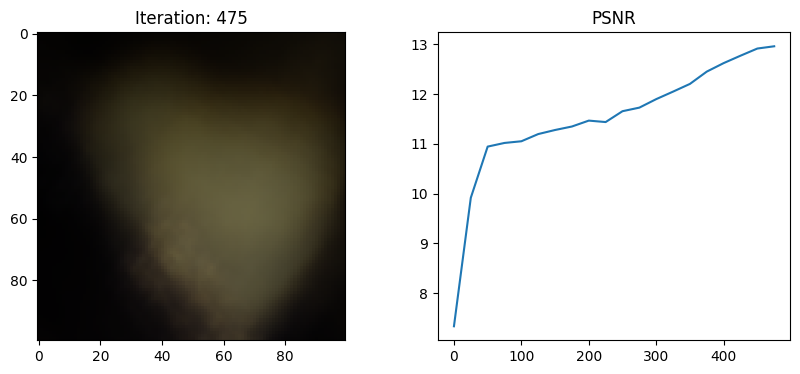

500 0.04859240531921387 secs per iter


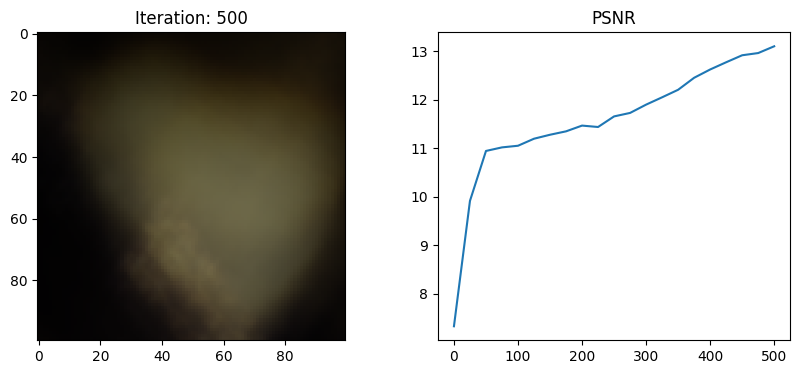

525 0.04860191345214844 secs per iter


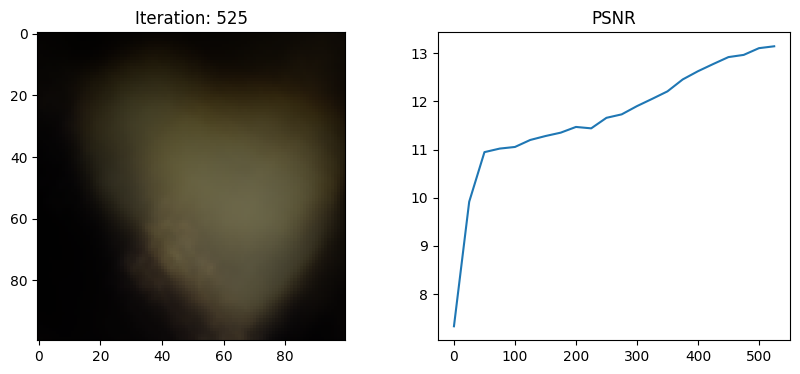

550 0.05647144317626953 secs per iter


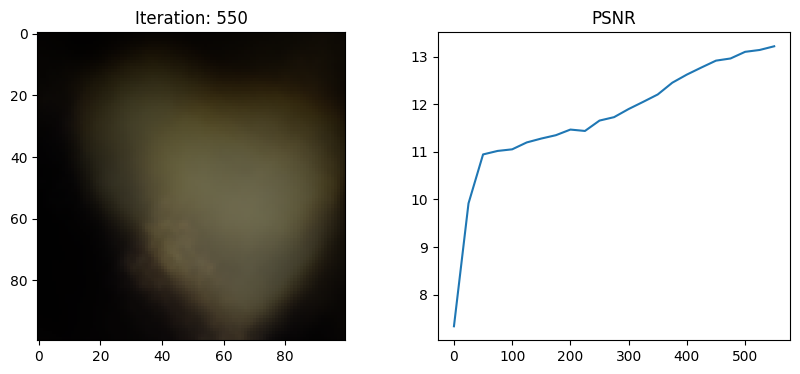

575 0.04874700546264649 secs per iter


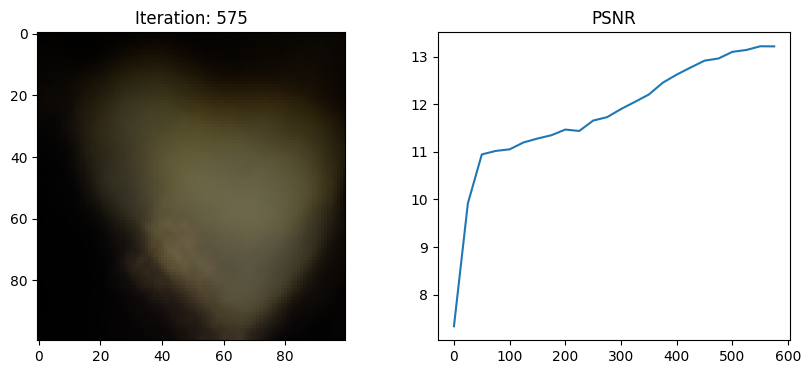

600 0.048521480560302734 secs per iter


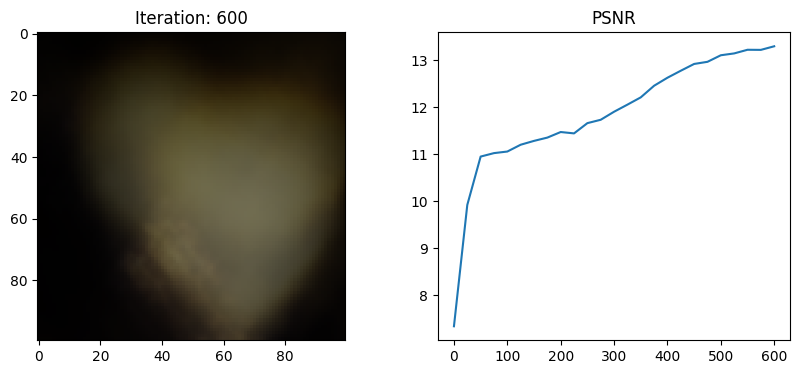

625 0.04882015228271484 secs per iter


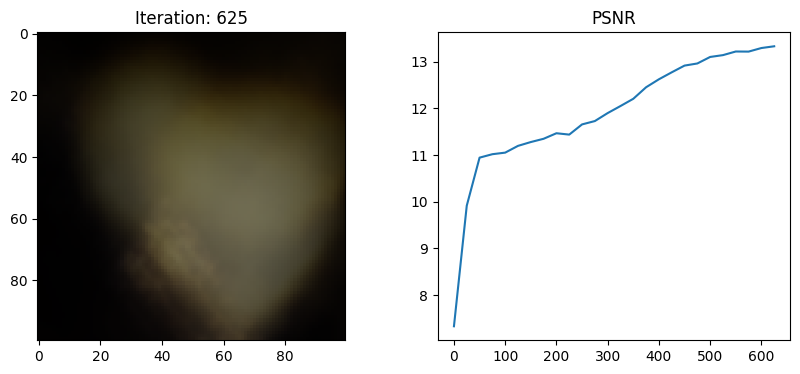

650 0.0498396110534668 secs per iter


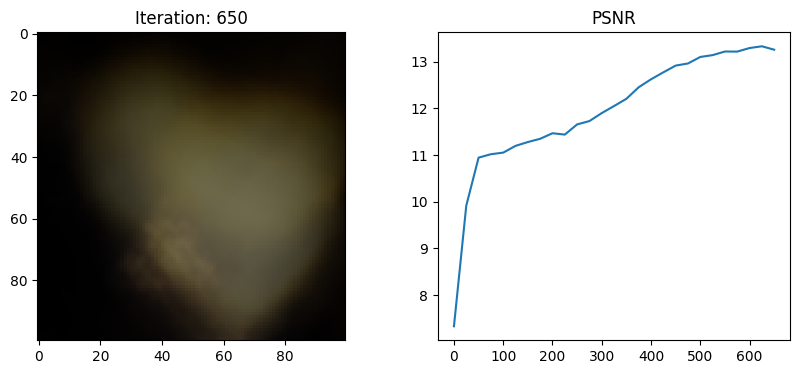

675 0.05060924530029297 secs per iter


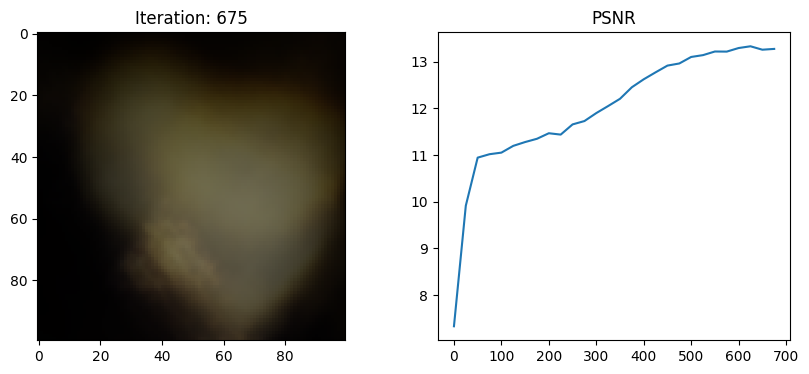

700 0.05509055137634277 secs per iter


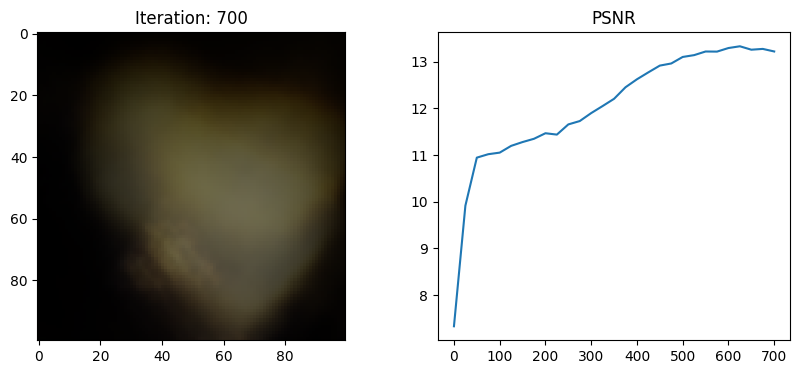

725 0.057868738174438474 secs per iter


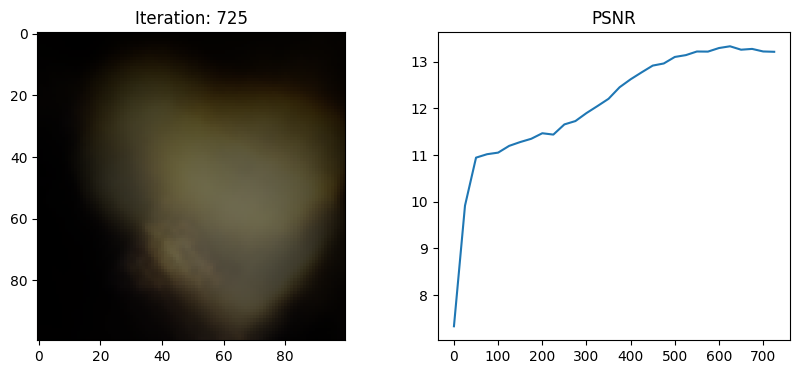

750 0.05015464782714844 secs per iter


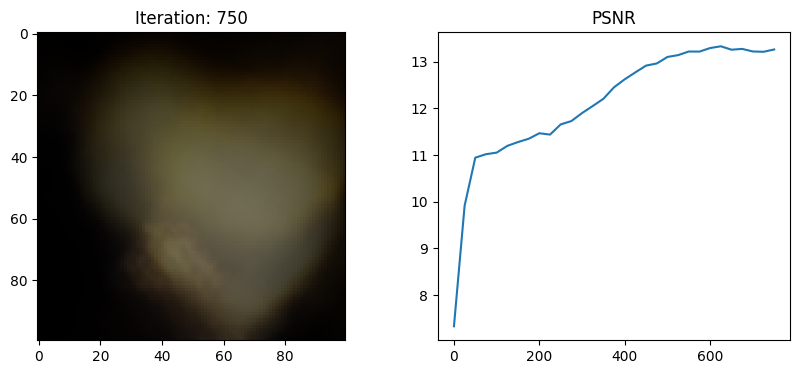

775 0.048210763931274415 secs per iter


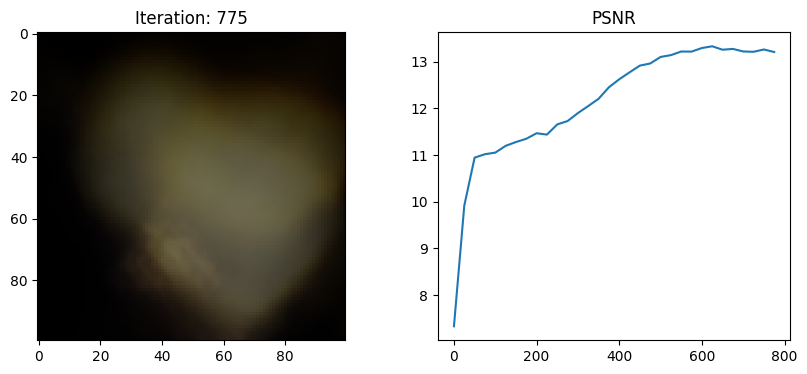

800 0.05010941505432129 secs per iter


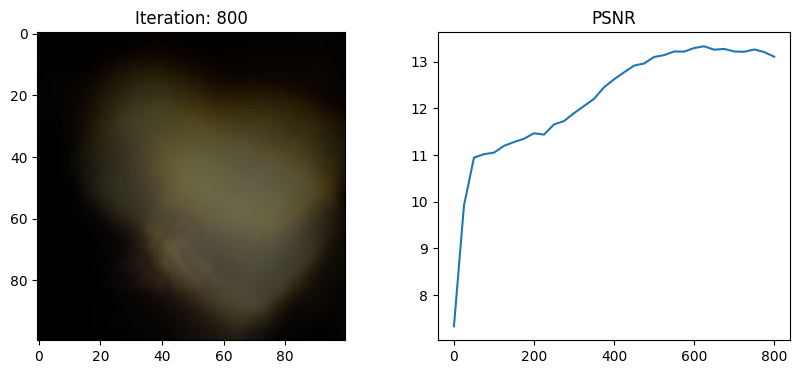

825 0.049802513122558595 secs per iter


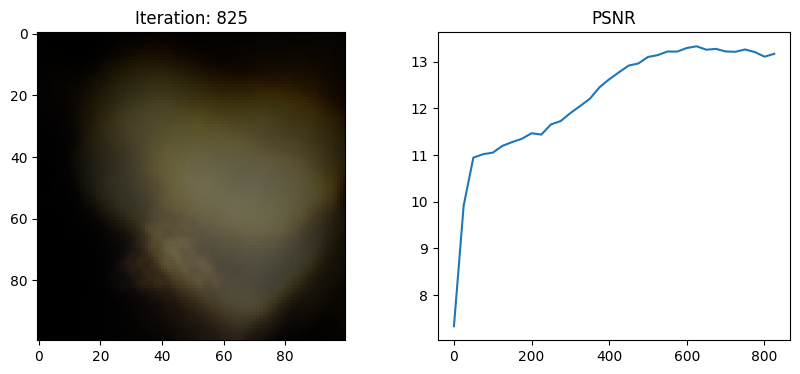

850 0.04980602264404297 secs per iter


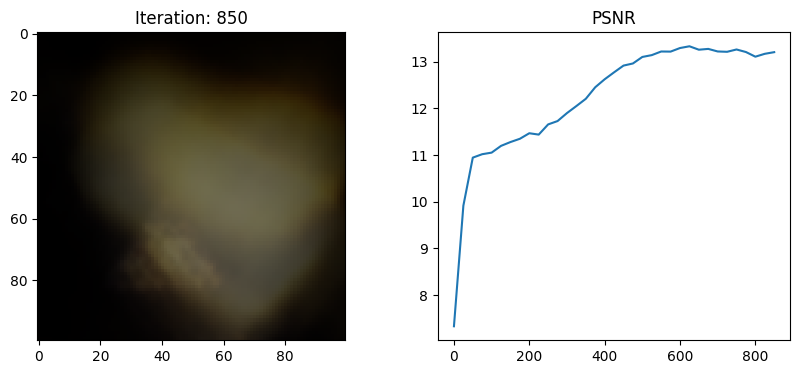

875 0.04981398582458496 secs per iter


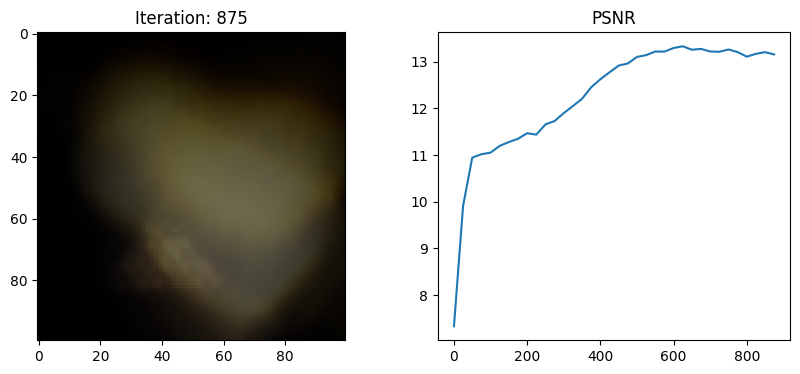

900 0.055536870956420896 secs per iter


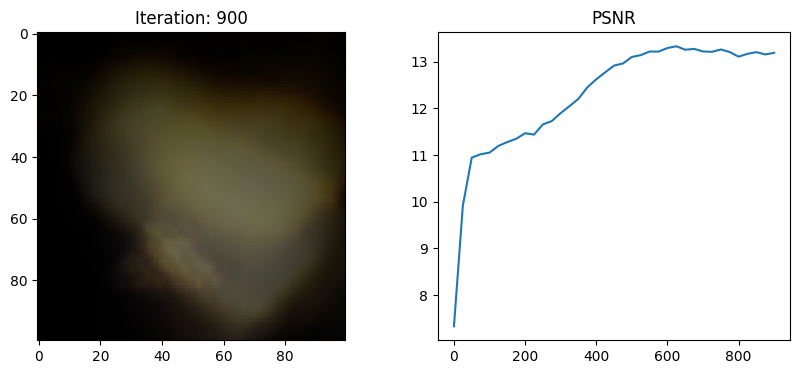

925 0.049064044952392576 secs per iter


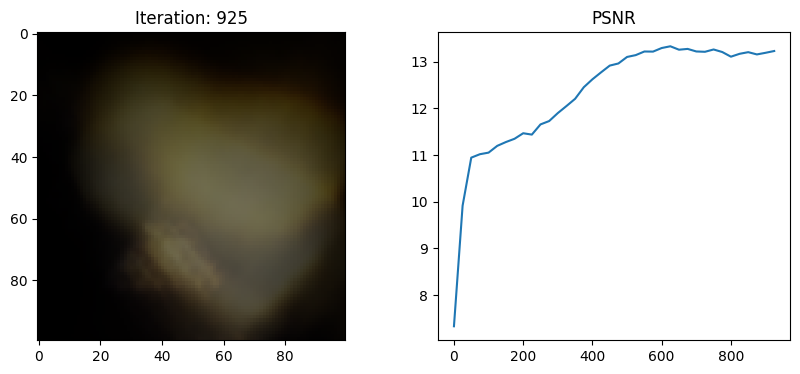

950 0.054522619247436524 secs per iter


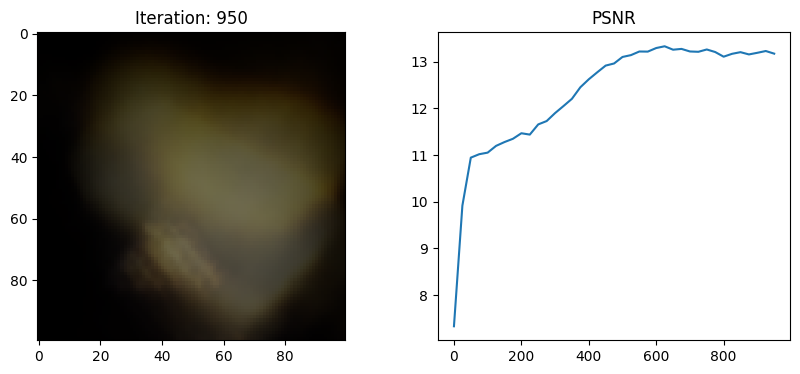

975 0.048200159072875975 secs per iter


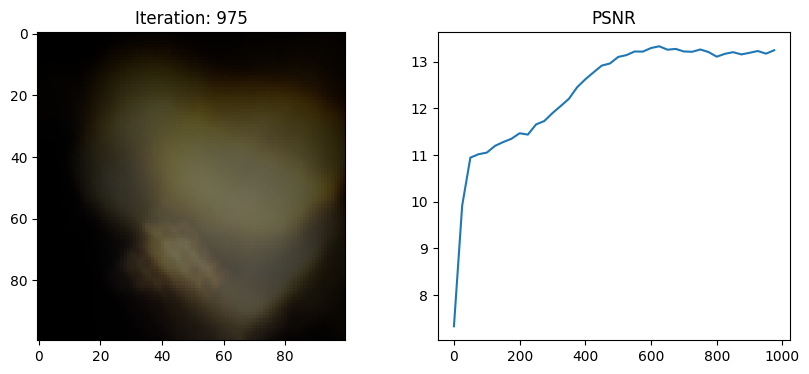

1000 0.04980592727661133 secs per iter


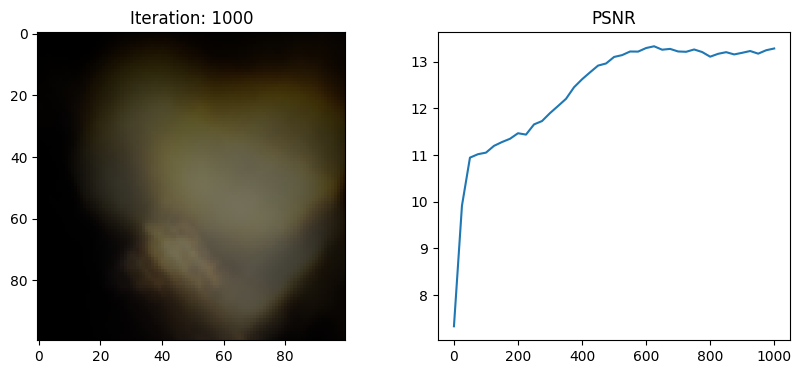

1025 0.04945603370666504 secs per iter


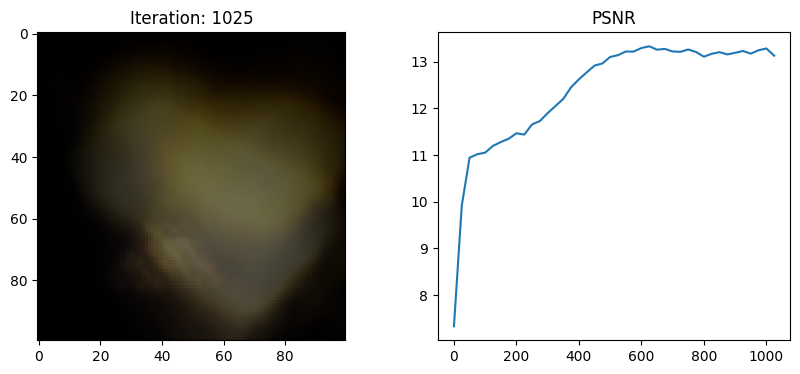

1050 0.04891587257385254 secs per iter


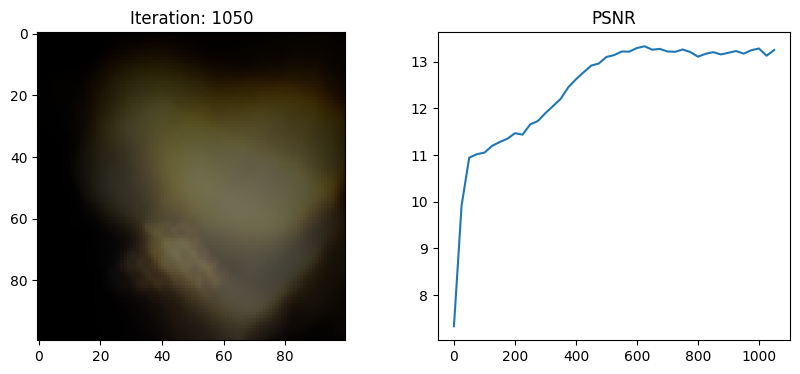

1075 0.04972222328186035 secs per iter


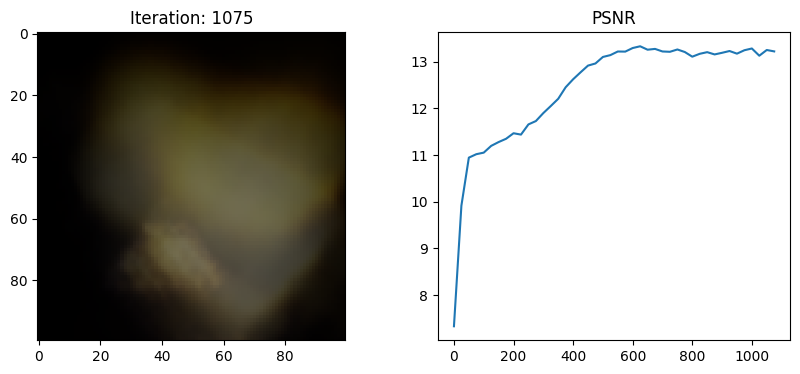

1100 0.049406938552856446 secs per iter


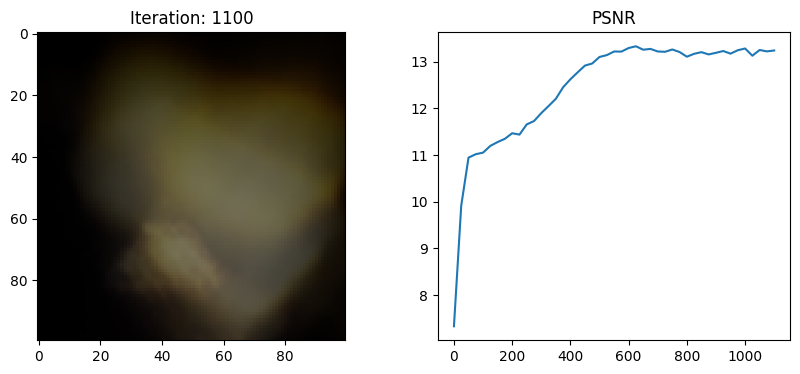

1125 0.049295473098754886 secs per iter


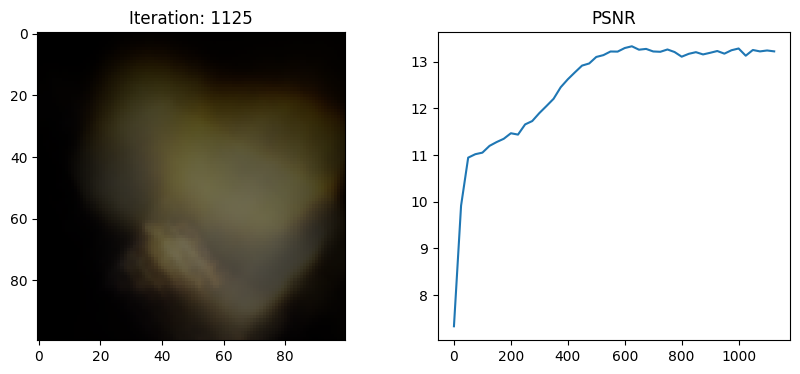

1150 0.04948546409606933 secs per iter


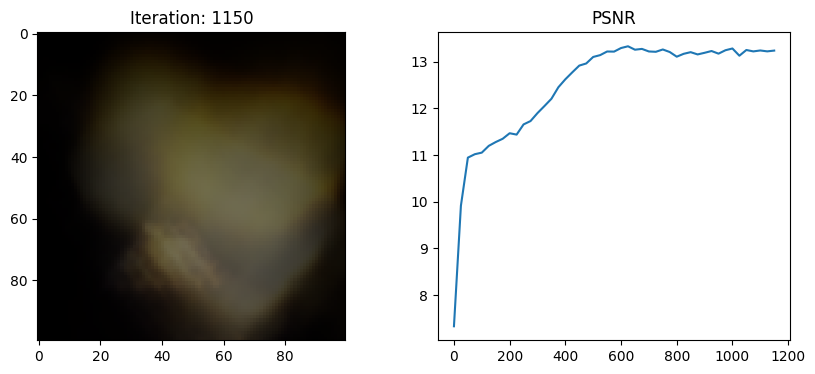

1175 0.05677141189575195 secs per iter


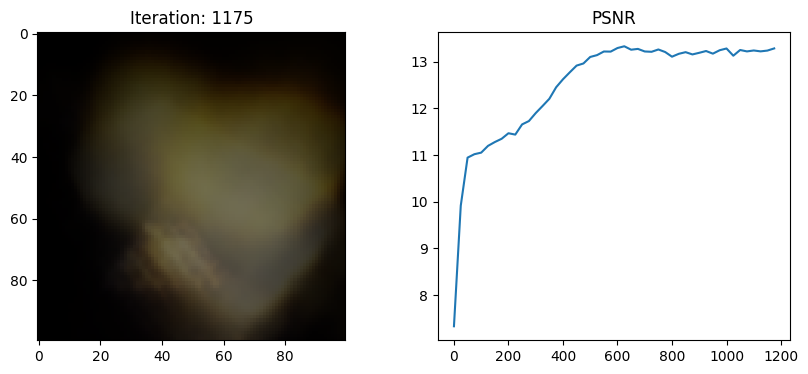

1200 0.056256103515625 secs per iter


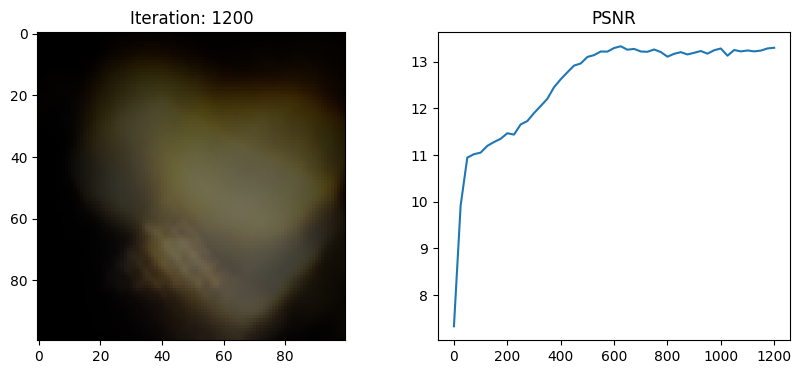

1225 0.04960705757141113 secs per iter


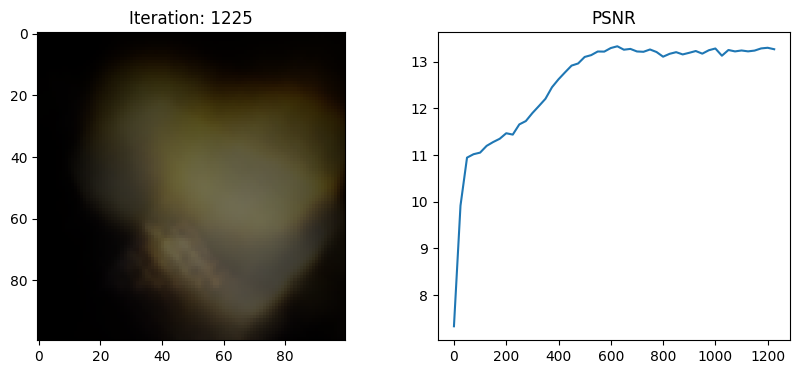

1250 0.05677332878112793 secs per iter


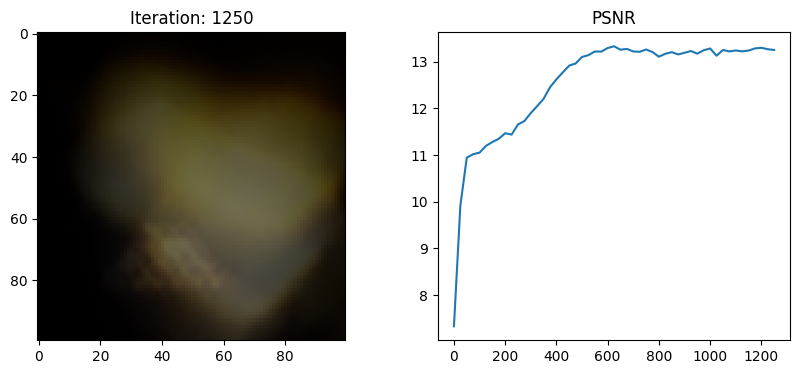

1275 0.04995497703552246 secs per iter


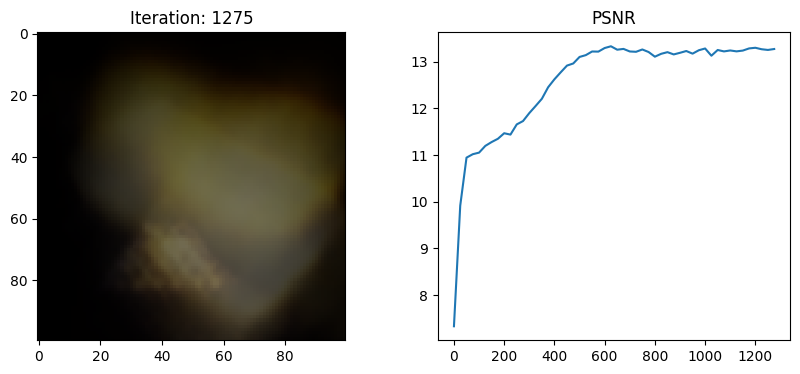

1300 0.04979680061340332 secs per iter


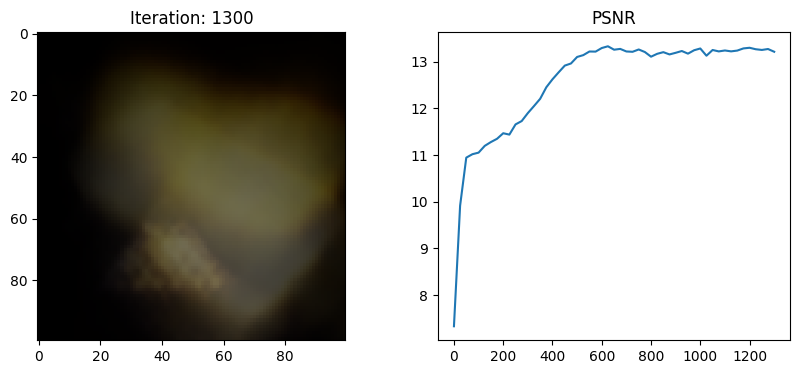

1325 0.049655799865722654 secs per iter


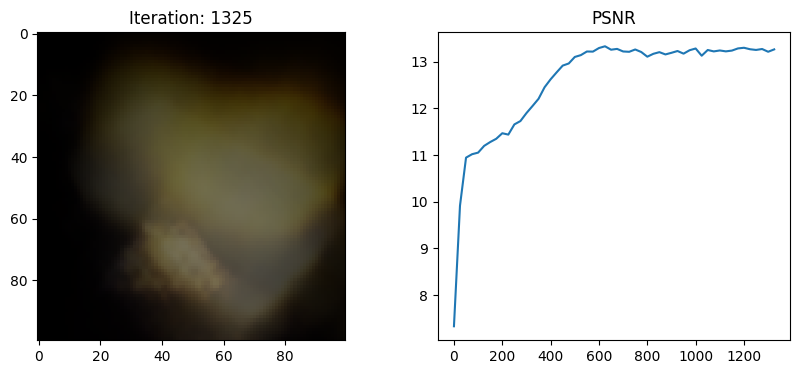

1350 0.049114198684692384 secs per iter


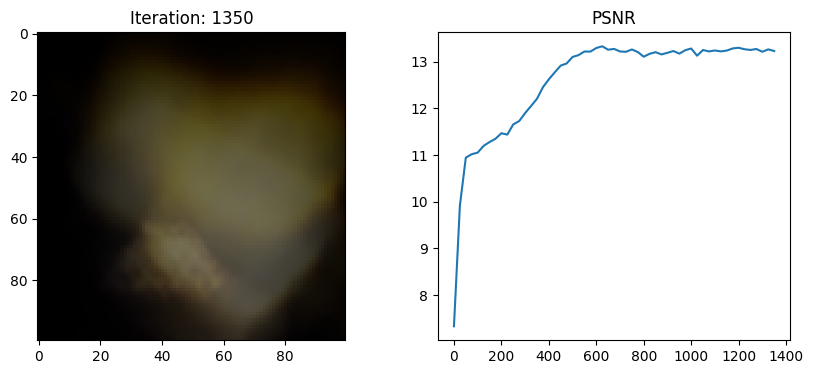

1375 0.05061767578125 secs per iter


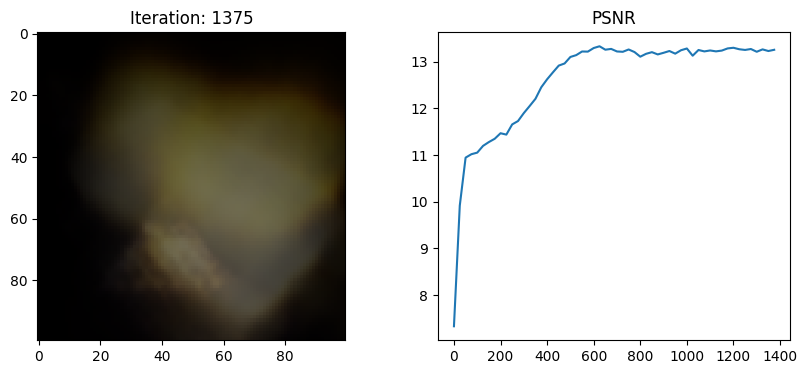

1400 0.053188323974609375 secs per iter


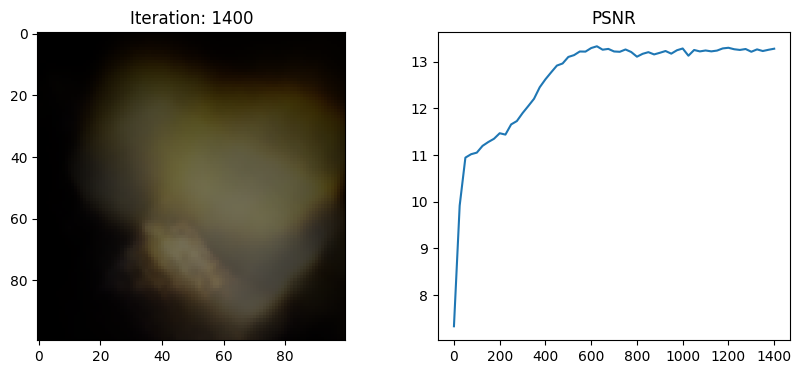

1425 0.05692302703857422 secs per iter


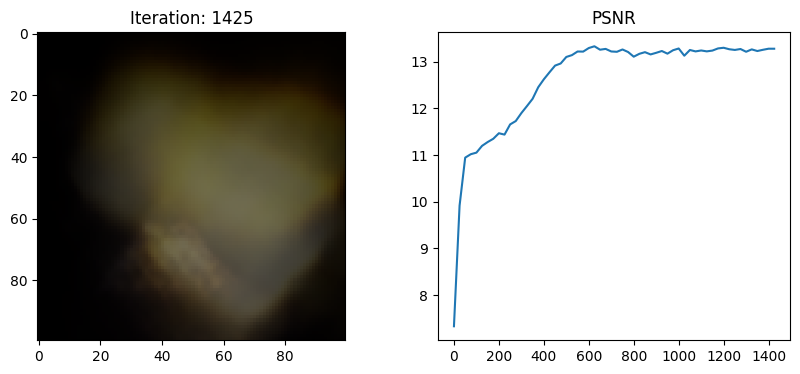

1450 0.050501441955566405 secs per iter


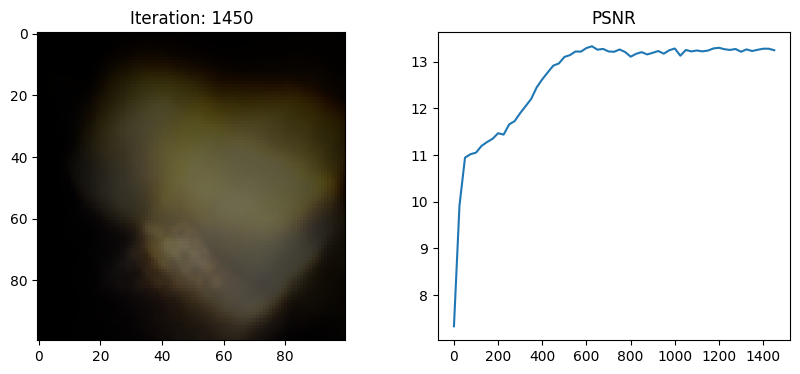

1475 0.05062582969665527 secs per iter


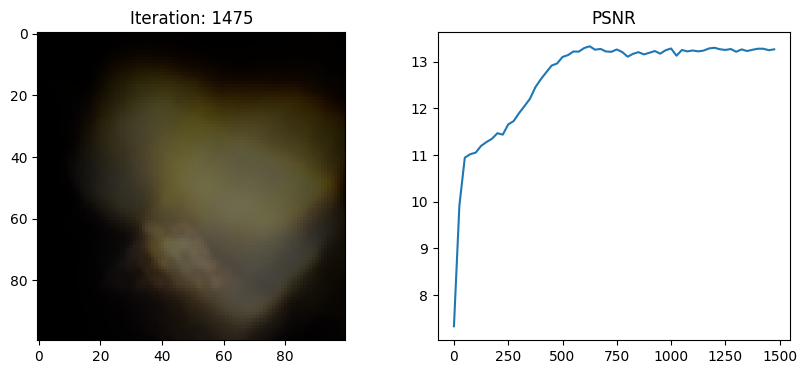

1500 0.050634298324584964 secs per iter


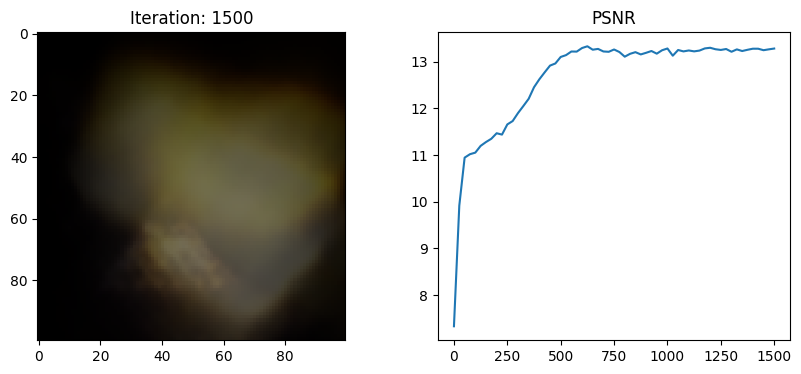

1525 0.04973306655883789 secs per iter


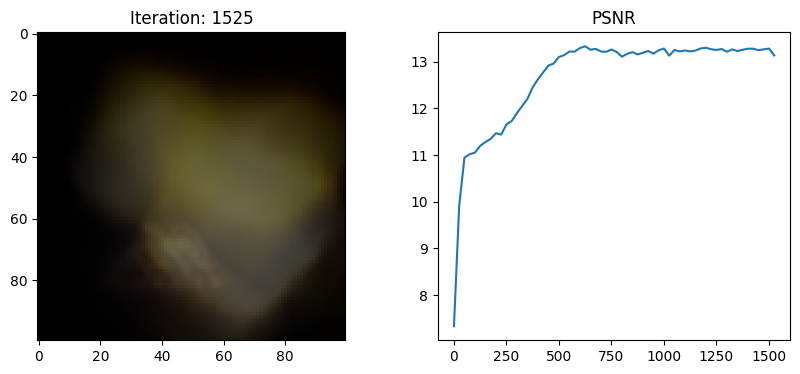

1550 0.04988004684448242 secs per iter


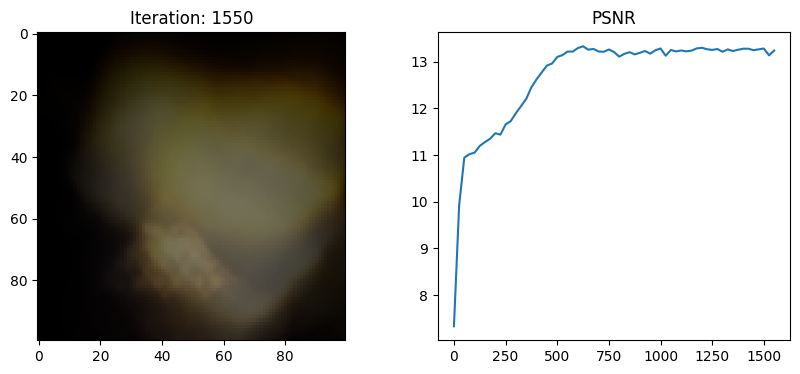

1575 0.04972525596618652 secs per iter


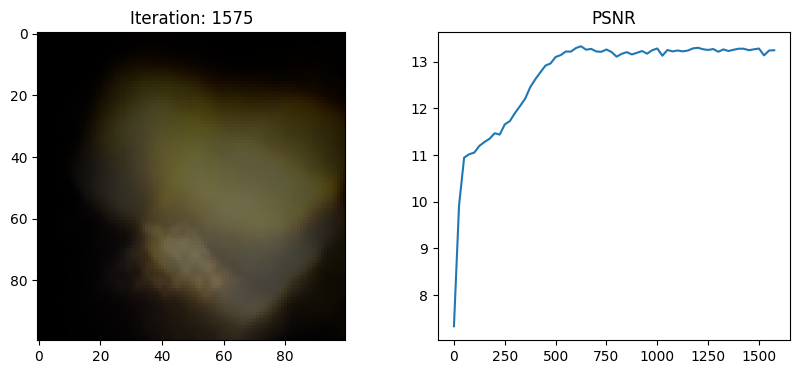

1600 0.056523399353027345 secs per iter


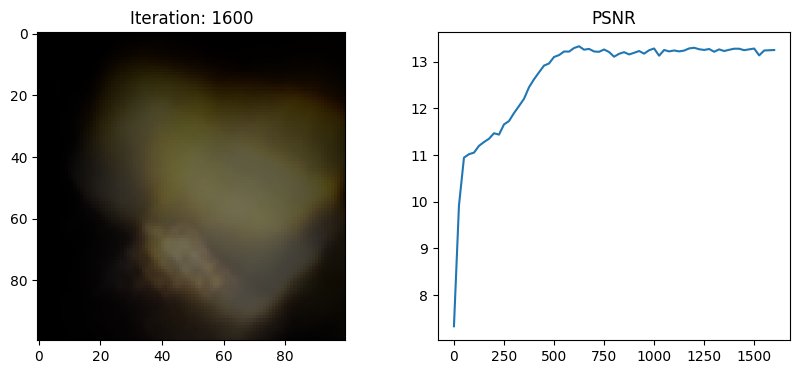

1625 0.05016323089599609 secs per iter


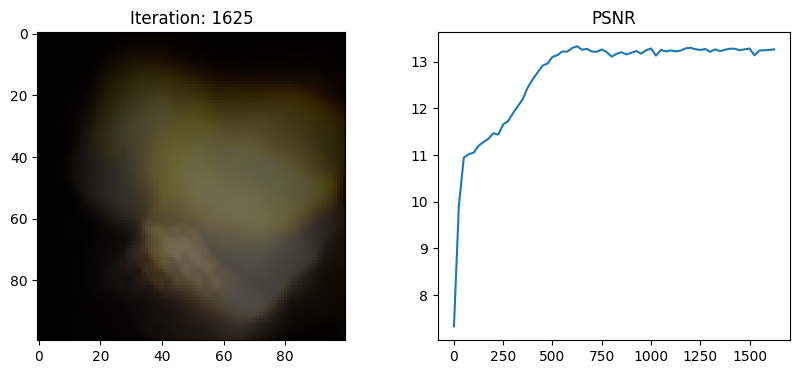

1650 0.05776825904846192 secs per iter


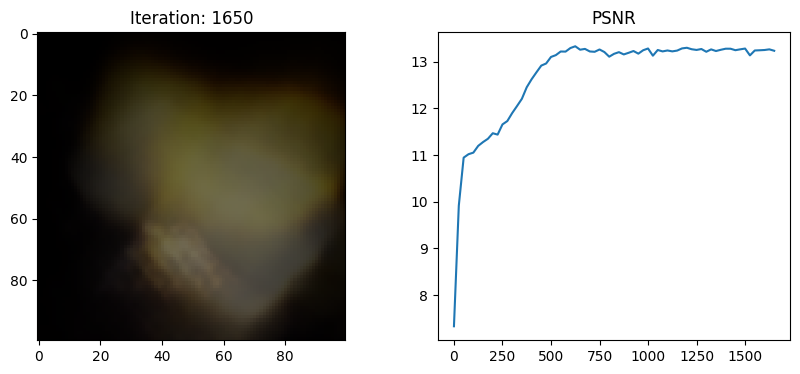

1675 0.04972893714904785 secs per iter


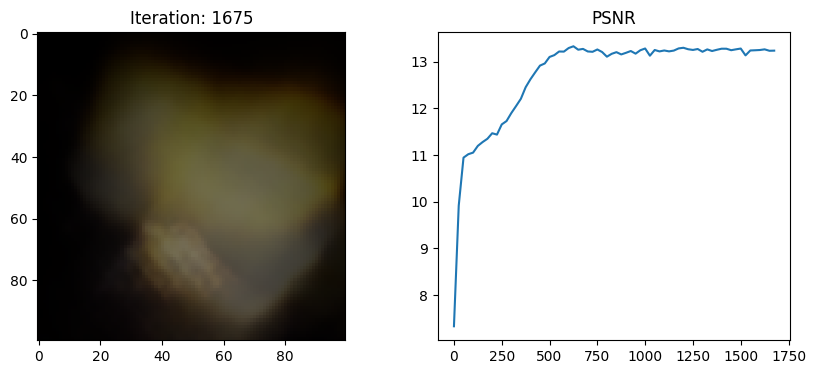

1700 0.05011122703552246 secs per iter


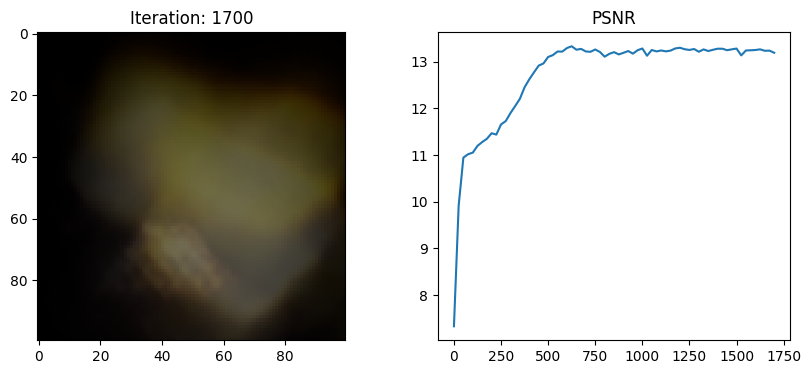

1725 0.053461675643920896 secs per iter


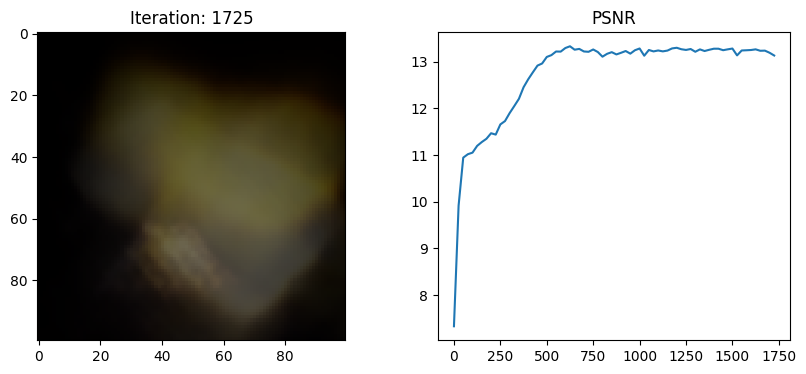

1750 0.055897159576416014 secs per iter


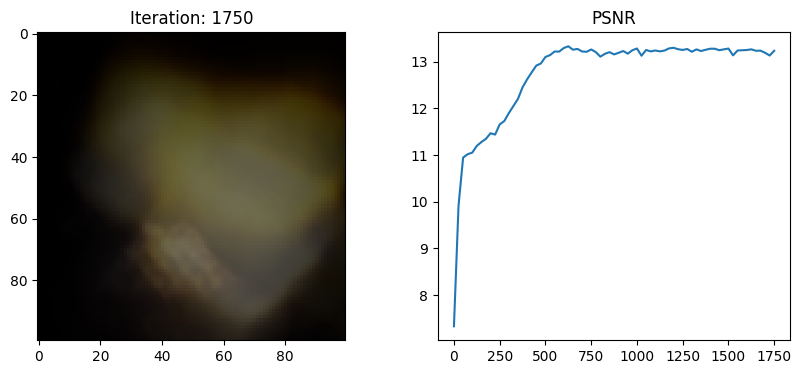

1775 0.06263752937316895 secs per iter


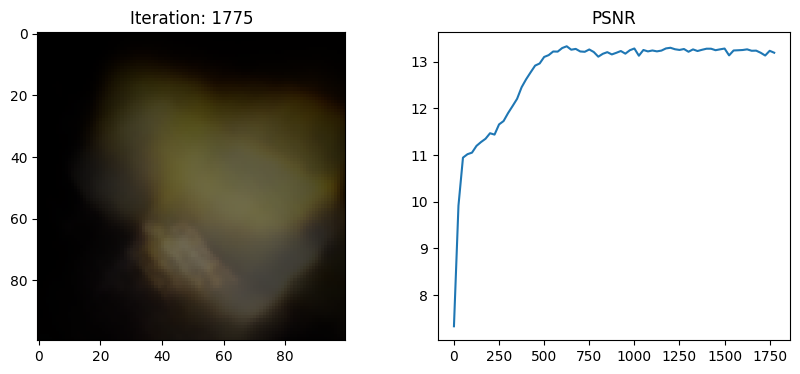

1800 0.050220184326171875 secs per iter


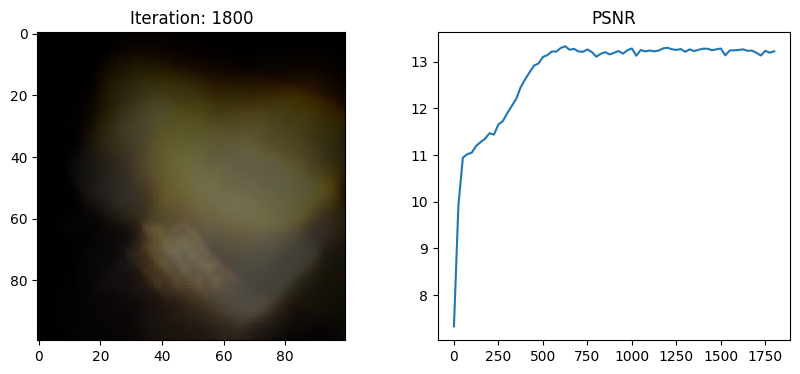

1825 0.051155195236206055 secs per iter


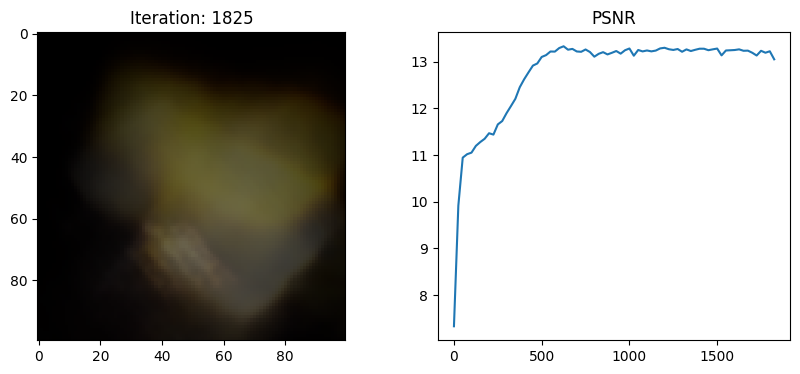

1850 0.04946291923522949 secs per iter


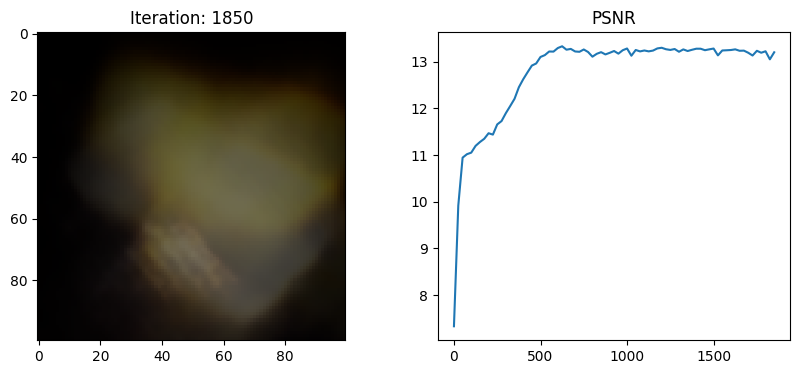

1875 0.05539240837097168 secs per iter


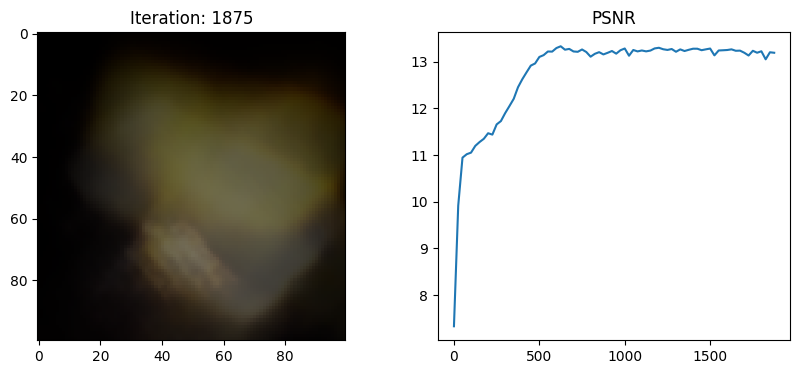

1900 0.049146842956542966 secs per iter


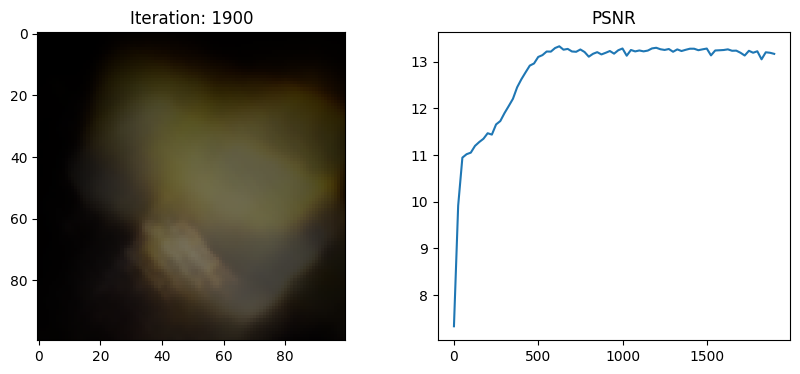

1925 0.04945206642150879 secs per iter


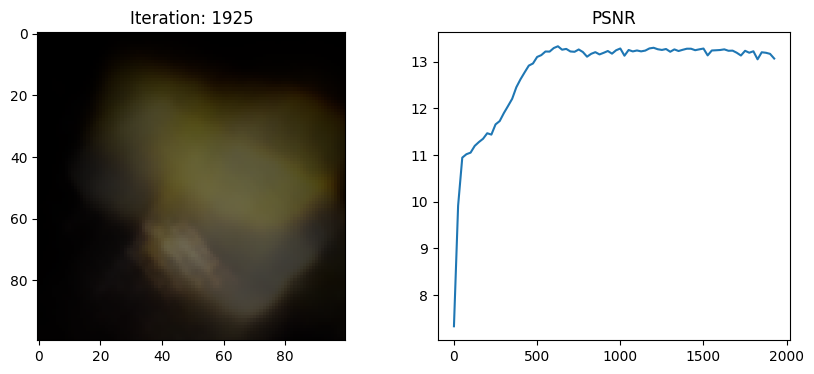

1950 0.05606237411499024 secs per iter


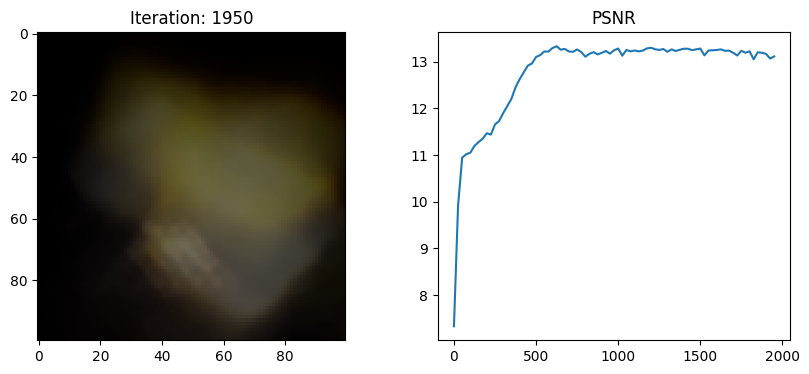

1975 0.04908479690551758 secs per iter


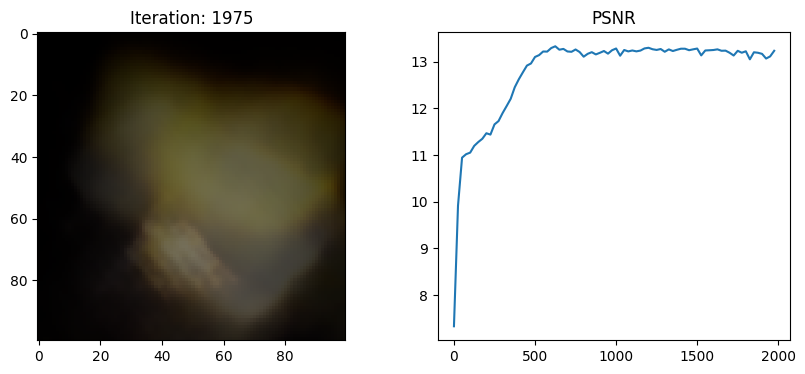

2000 0.048782243728637695 secs per iter


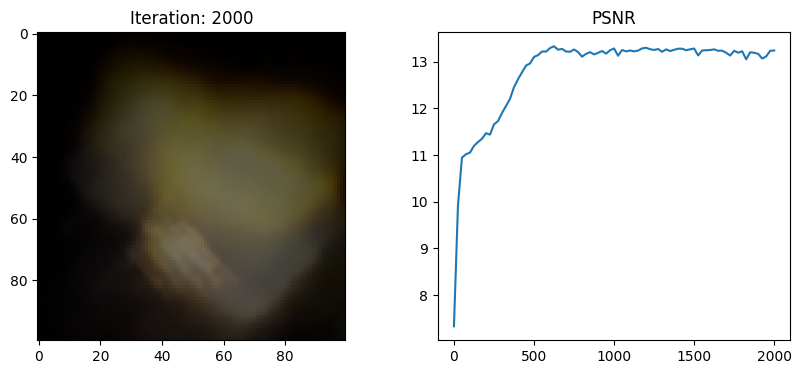

2025 0.050106983184814456 secs per iter


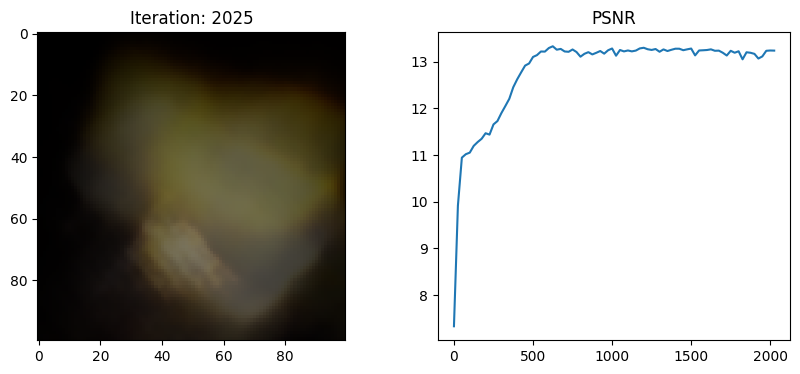

2050 0.049659080505371093 secs per iter


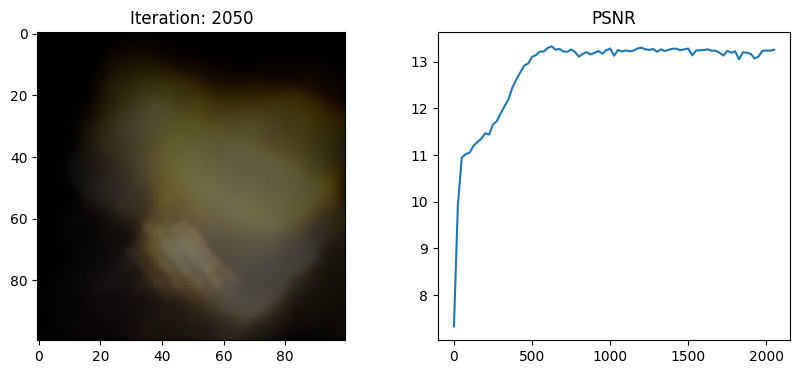

2075 0.04922700881958008 secs per iter


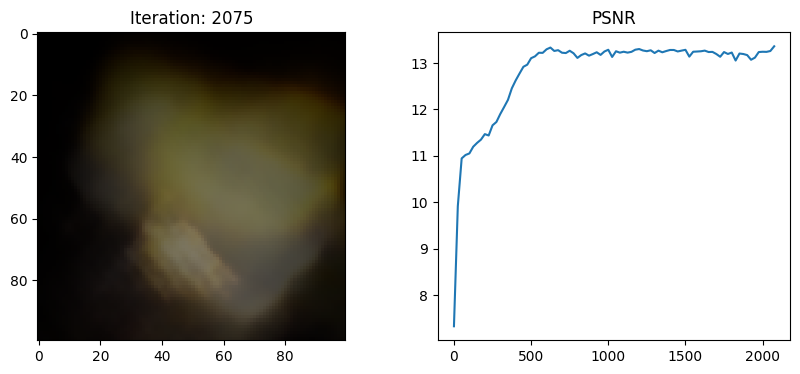

2100 0.055601282119750975 secs per iter


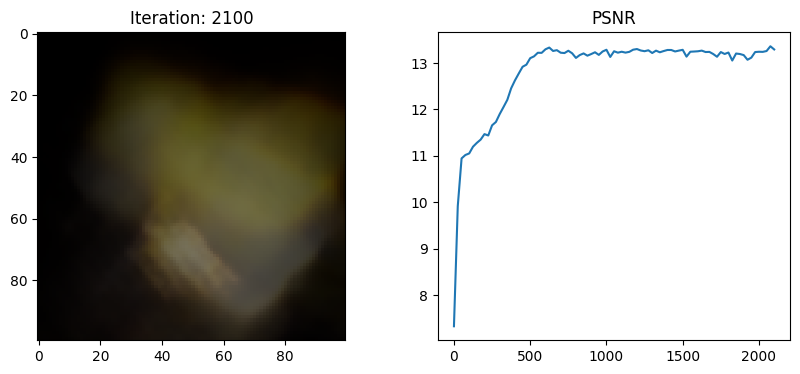

2125 0.05562640190124512 secs per iter


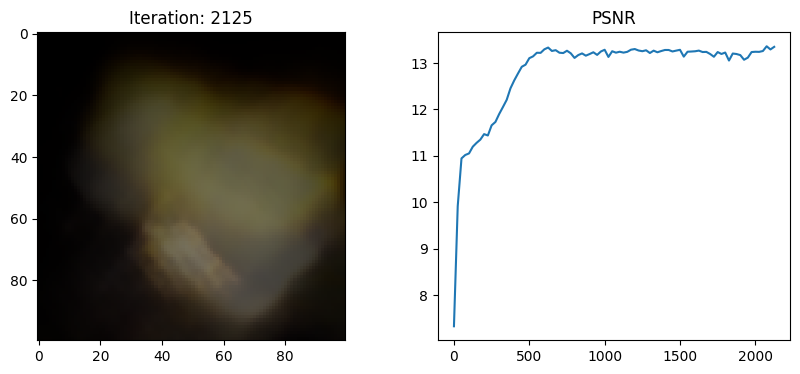

2150 0.04871742248535156 secs per iter


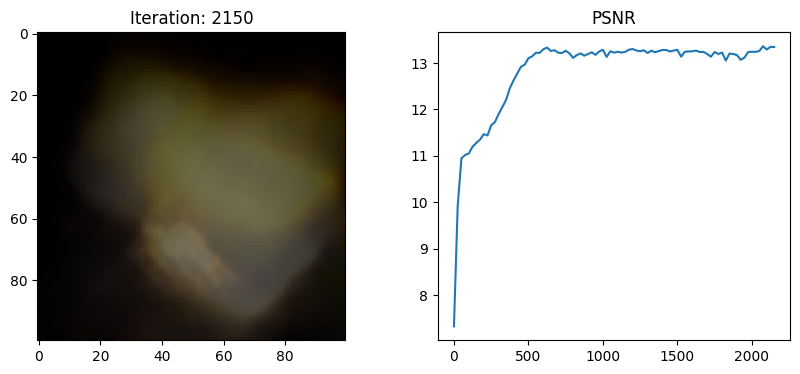

2175 0.04877507209777832 secs per iter


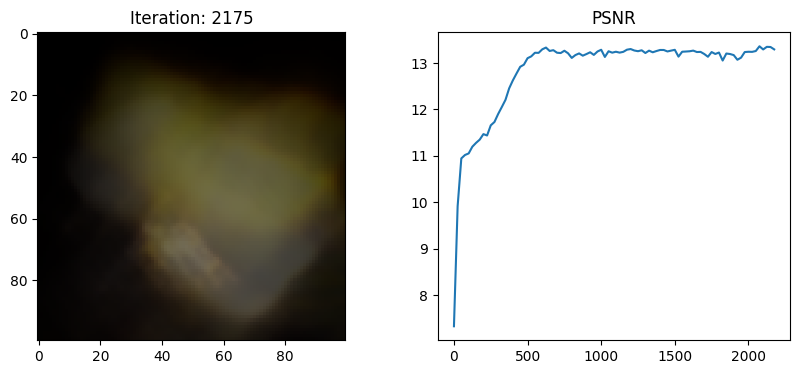

2200 0.04917098045349121 secs per iter


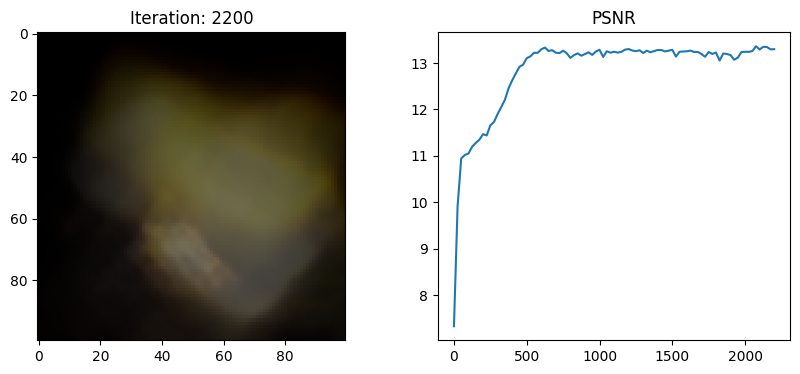

2225 0.04957481384277344 secs per iter


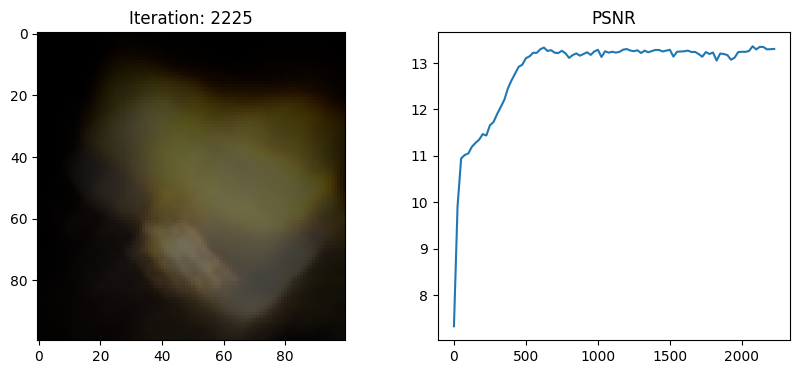

2250 0.050289878845214846 secs per iter


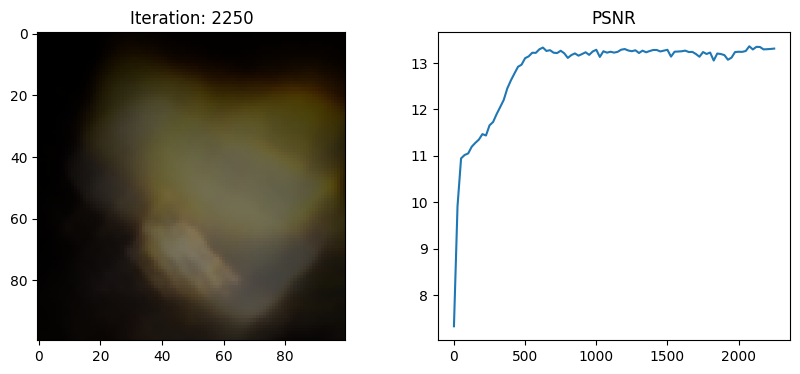

2275 0.04901620864868164 secs per iter


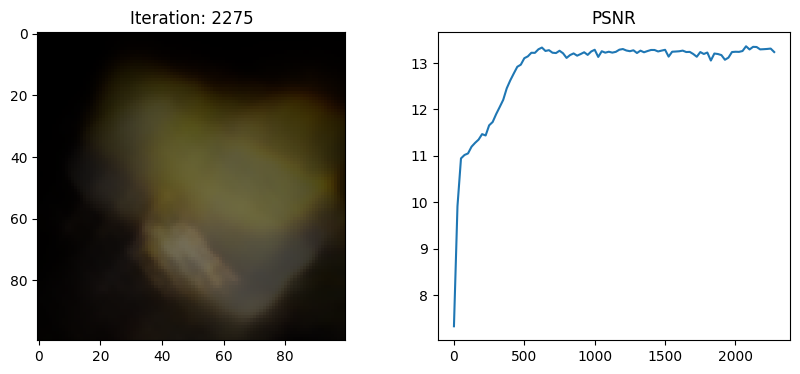

2300 0.04950203895568848 secs per iter


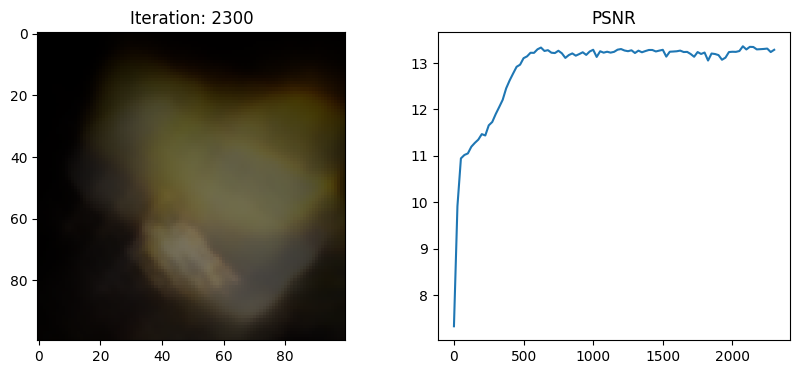

2325 0.04996199607849121 secs per iter


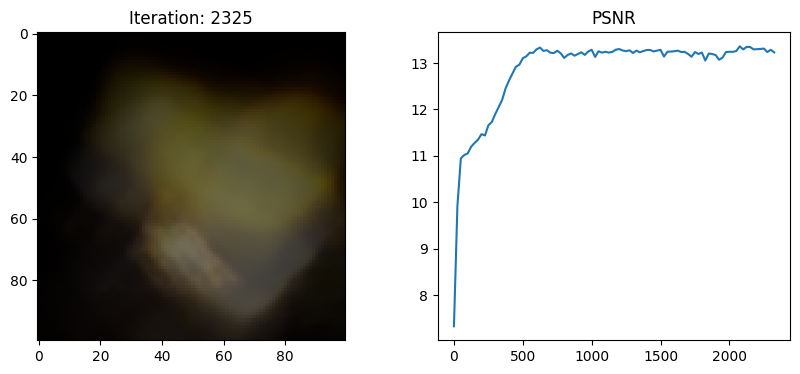

2350 0.0636287784576416 secs per iter


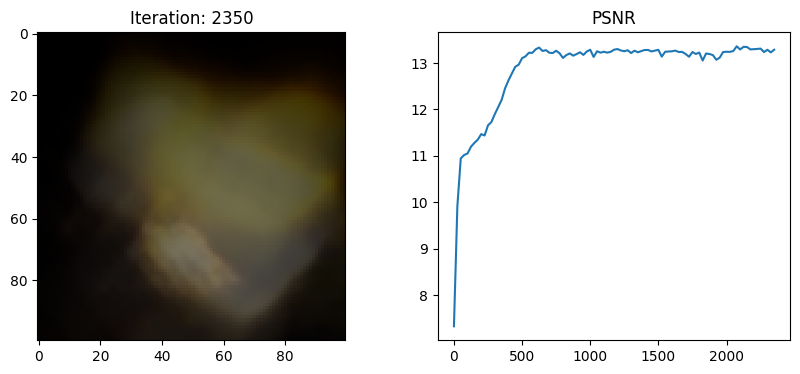

2375 0.0499000072479248 secs per iter


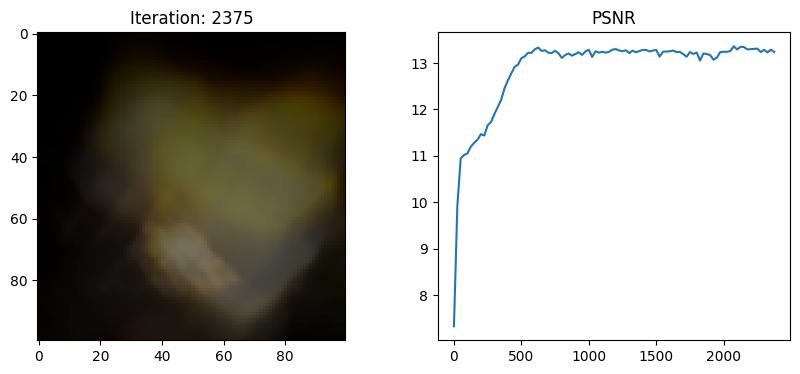

2400 0.04949847221374512 secs per iter


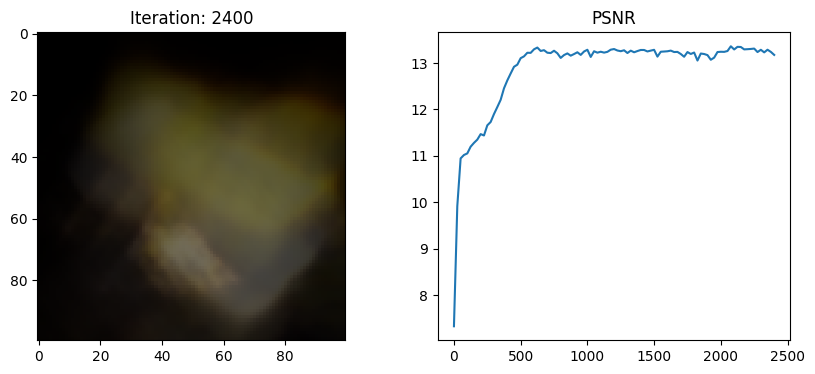

2425 0.049585151672363284 secs per iter


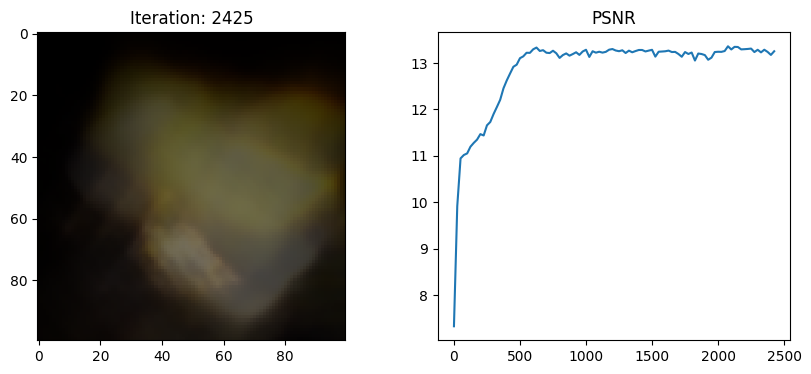

2450 0.049677553176879885 secs per iter


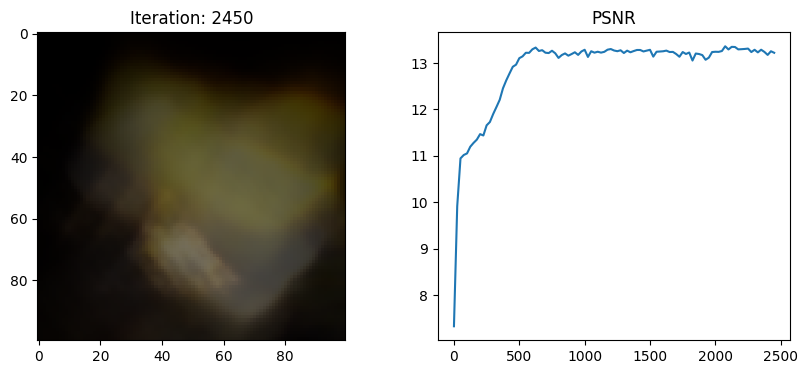

2475 0.049411497116088866 secs per iter


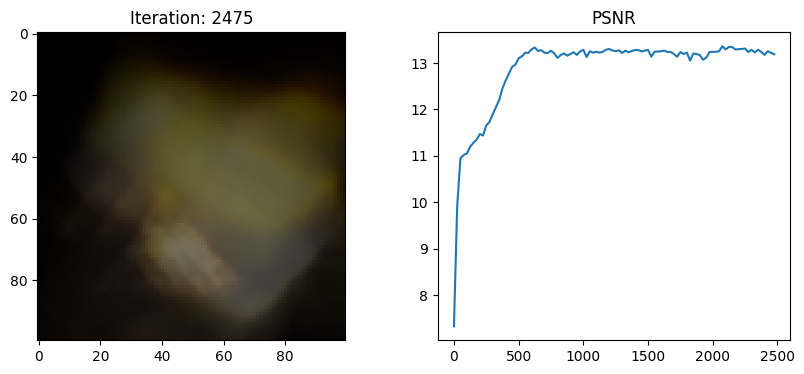

2500 0.049616527557373044 secs per iter


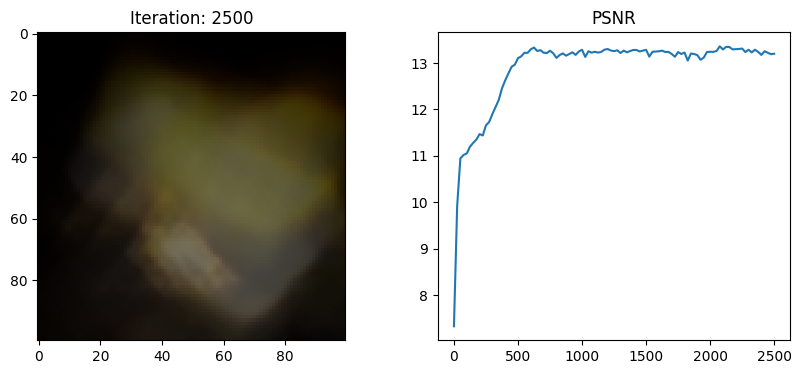

2525 0.0494821834564209 secs per iter


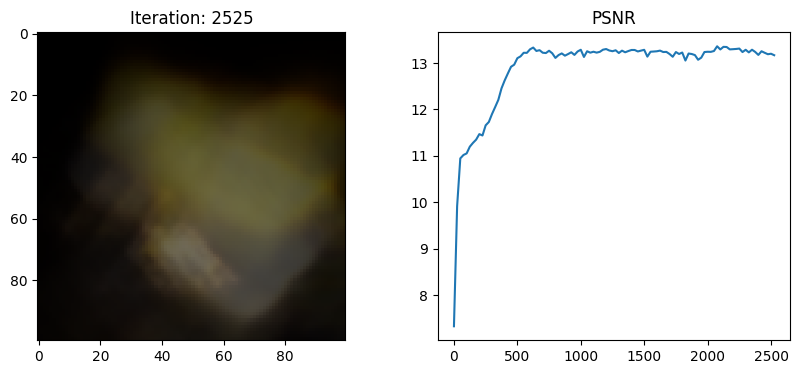

2550 0.05014361381530762 secs per iter


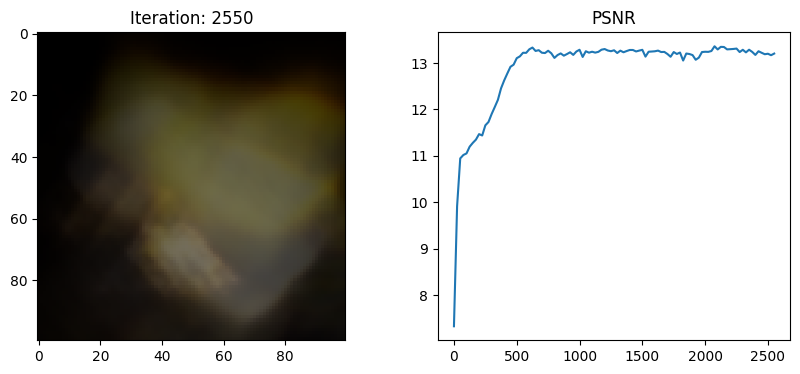

2575 0.056724443435668945 secs per iter


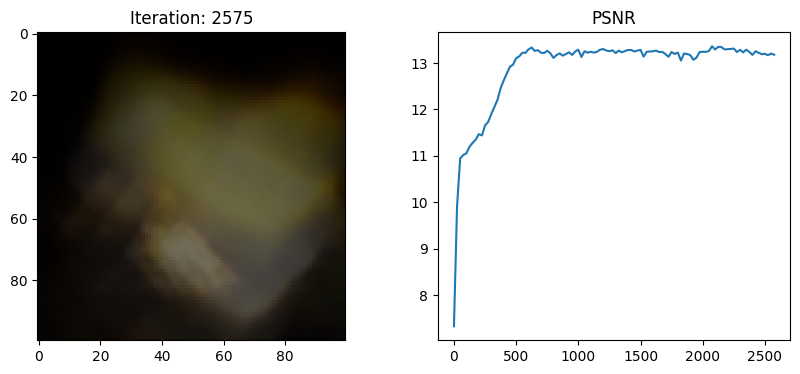

2600 0.05558627128601074 secs per iter


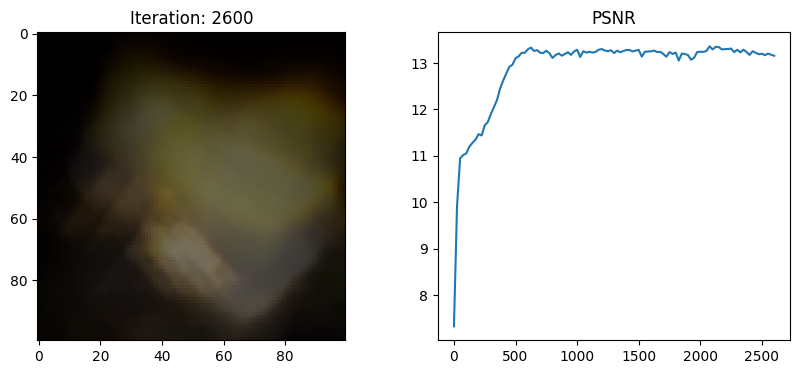

2625 0.05686953544616699 secs per iter


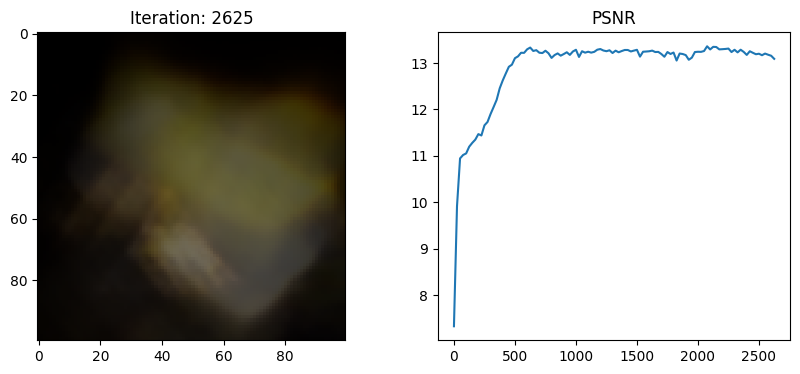

2650 0.056417169570922854 secs per iter


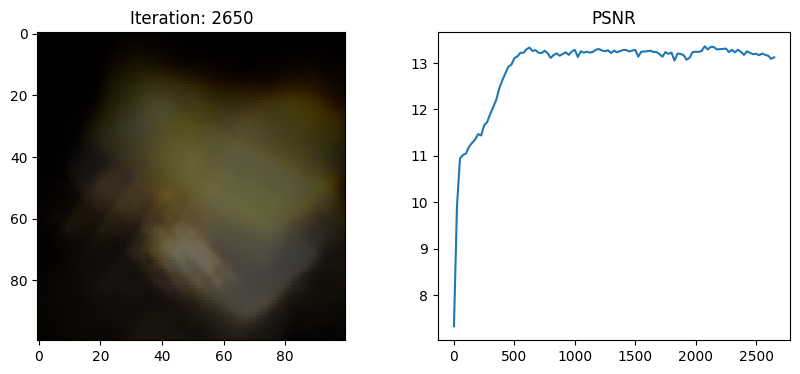

2675 0.05067625999450684 secs per iter


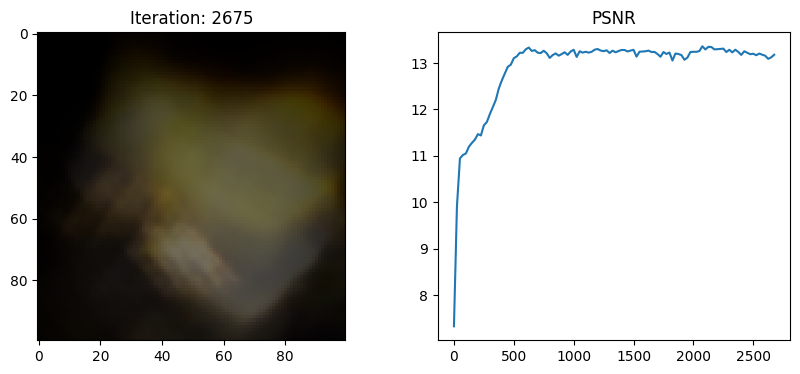

2700 0.05719705581665039 secs per iter


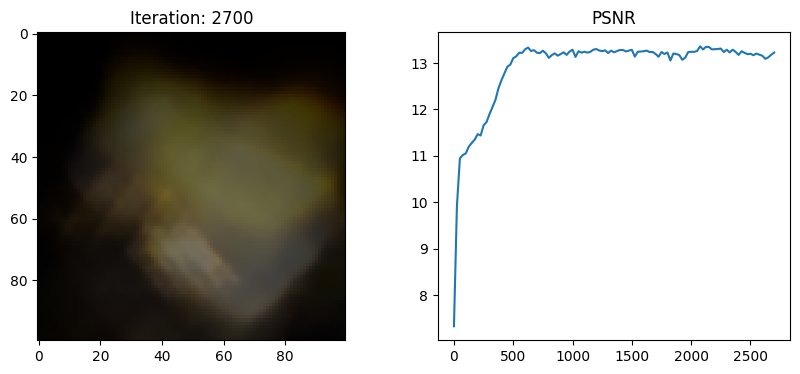

2725 0.049477672576904295 secs per iter


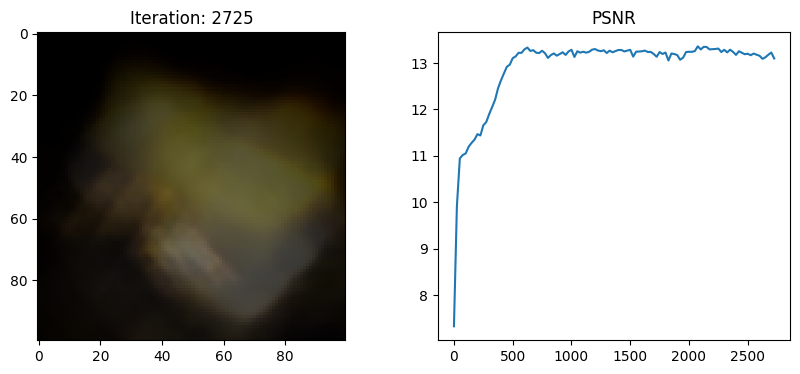

2750 0.05012938499450684 secs per iter


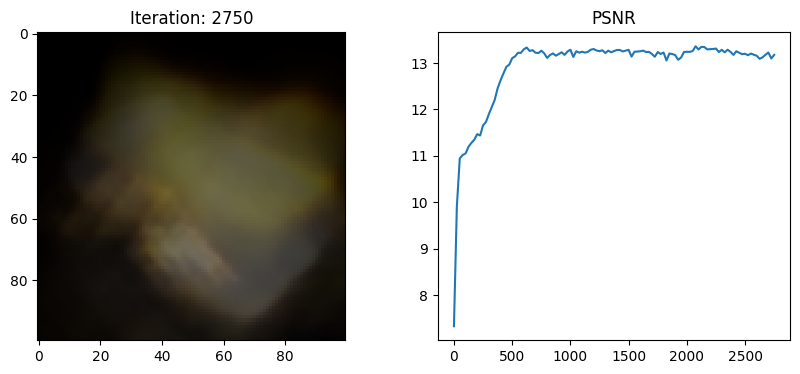

2775 0.0501947021484375 secs per iter


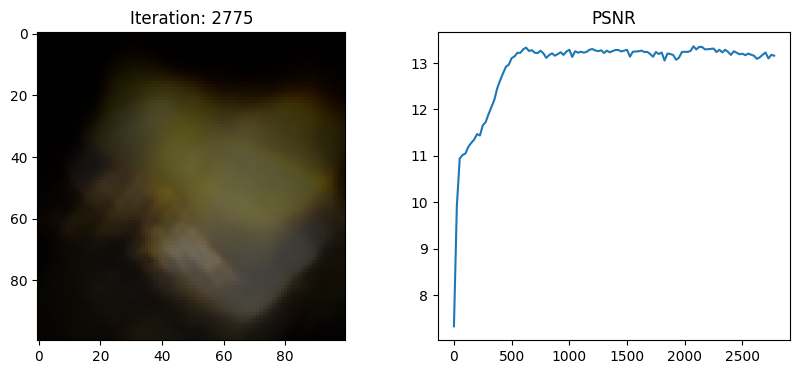

2800 0.057026453018188476 secs per iter


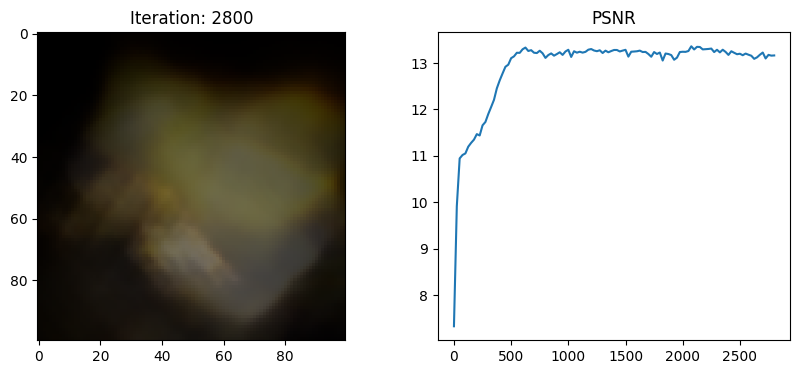

2825 0.054666662216186525 secs per iter


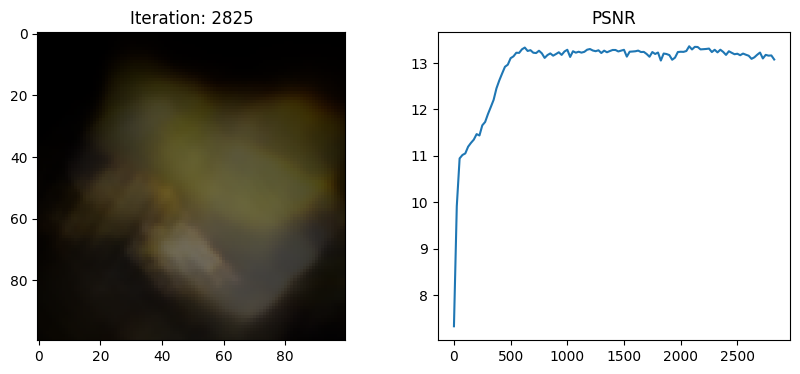

2850 0.04956171035766602 secs per iter


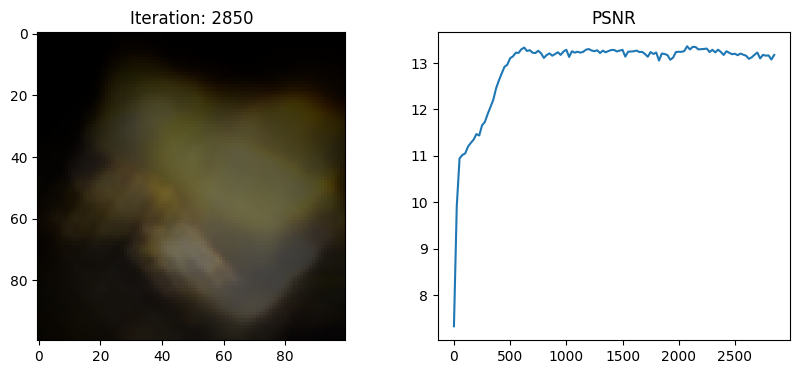

2875 0.05045381546020508 secs per iter


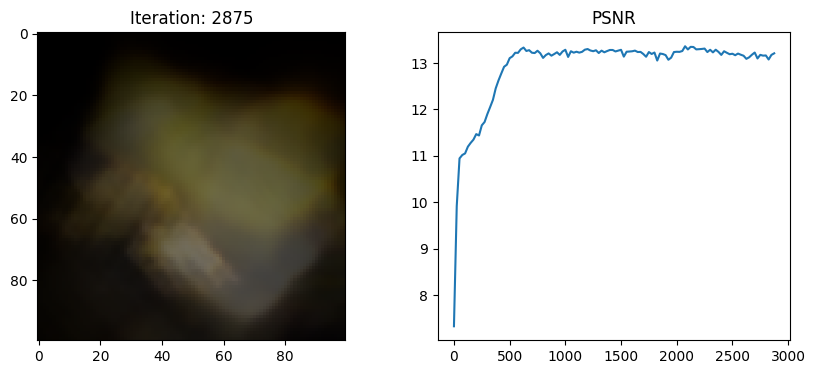

2900 0.05005499839782715 secs per iter


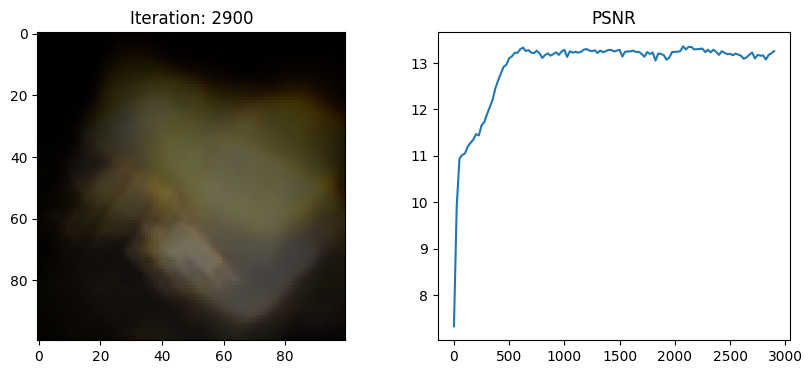

2925 0.0503757381439209 secs per iter


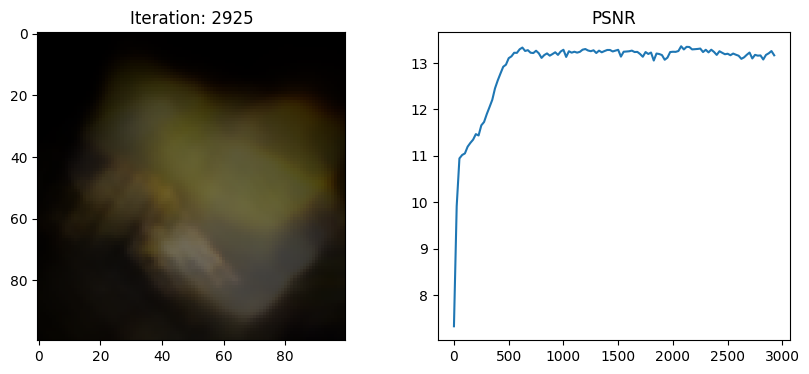

2950 0.04974431991577148 secs per iter


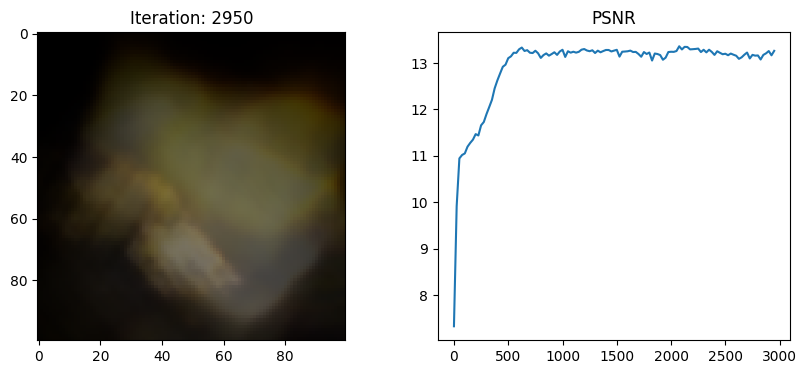

2975 0.05021059989929199 secs per iter


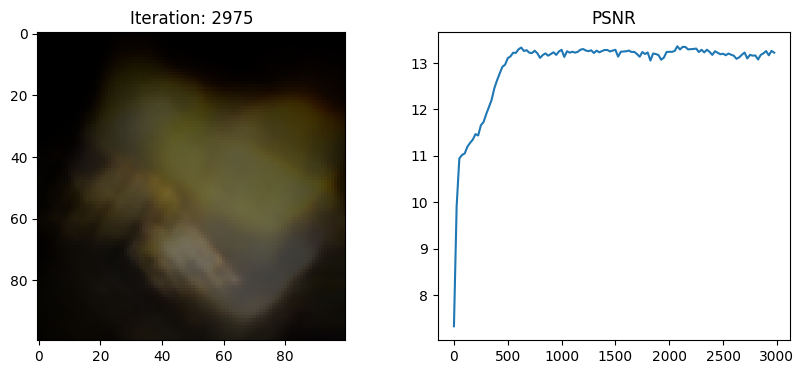

3000 0.05070304870605469 secs per iter


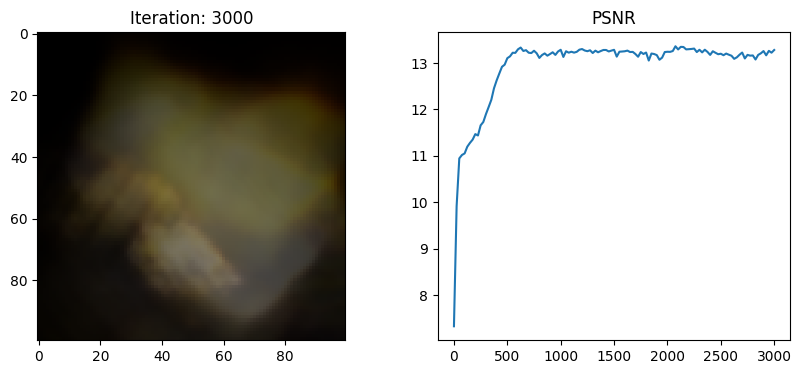

3025 0.05118927001953125 secs per iter


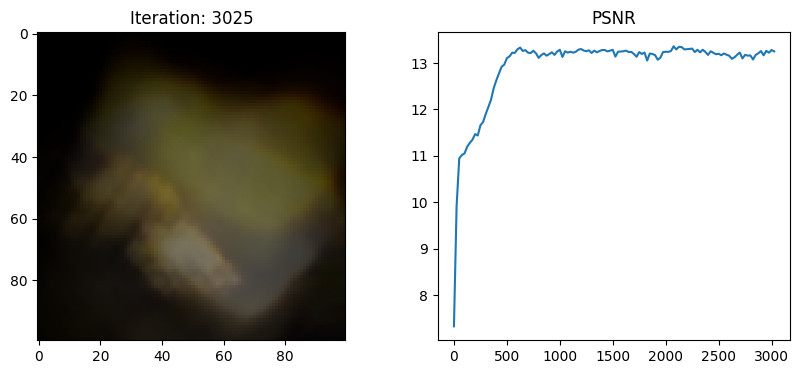

3050 0.06399576187133789 secs per iter


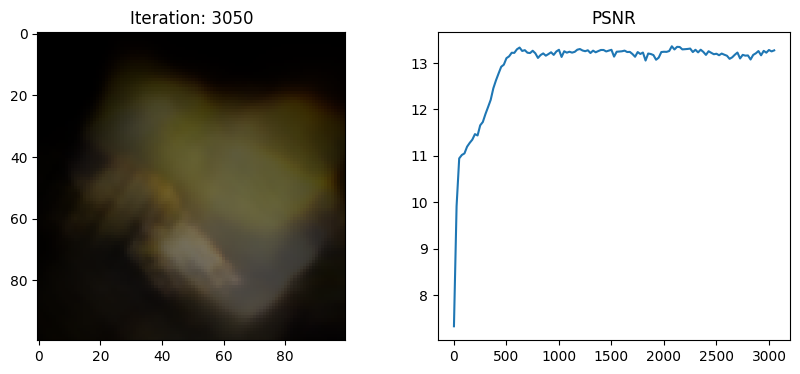

3075 0.050536584854125974 secs per iter


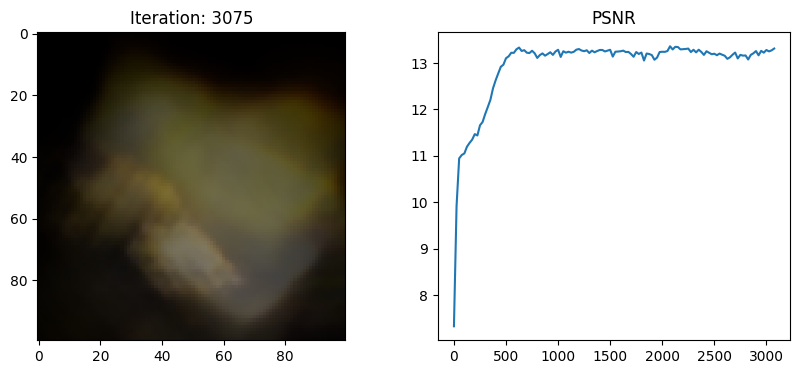

3100 0.05037373542785645 secs per iter


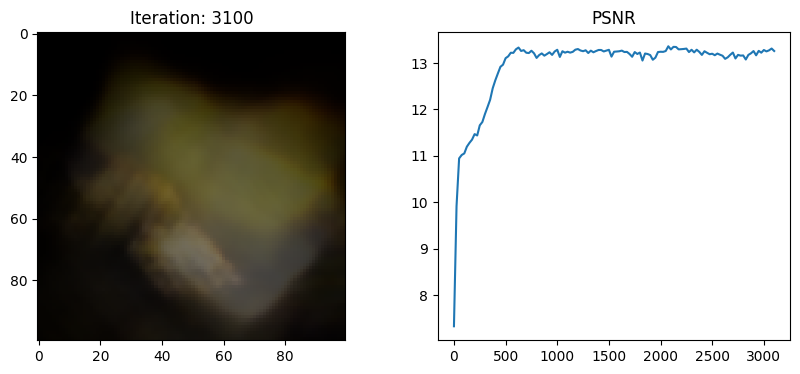

3125 0.05103022575378418 secs per iter


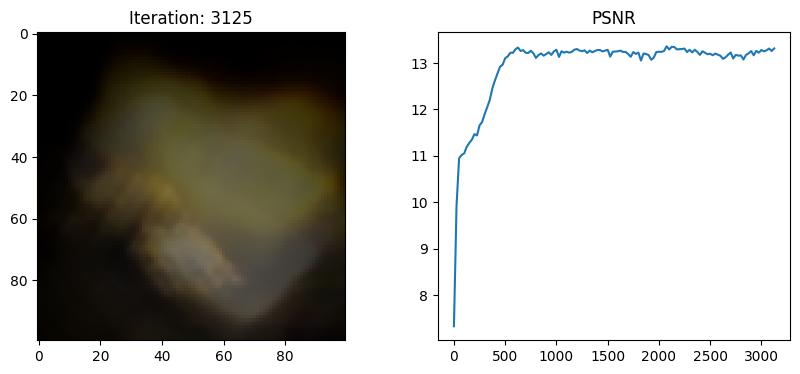

3150 0.050351219177246095 secs per iter


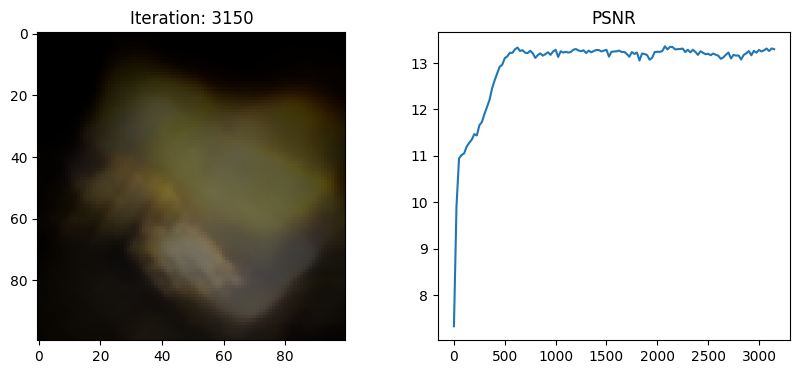

3175 0.05029467582702637 secs per iter


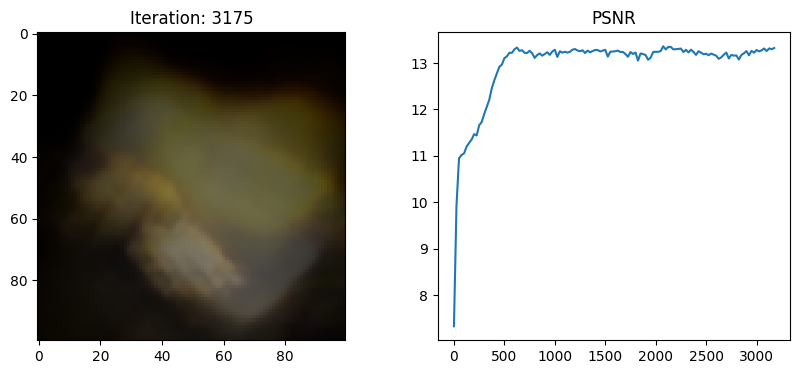

3200 0.0506729793548584 secs per iter


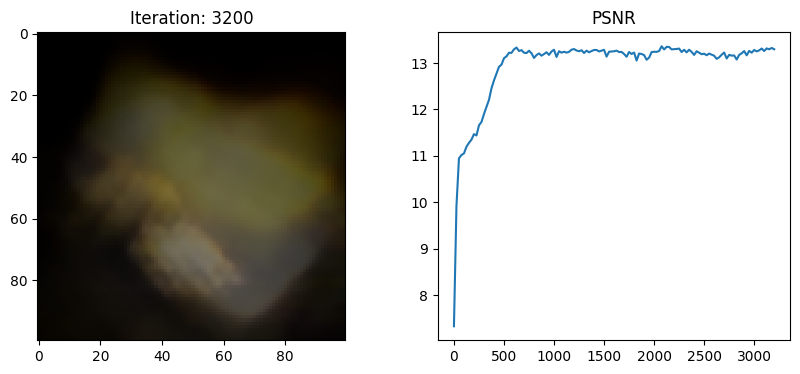

3225 0.05071889877319336 secs per iter


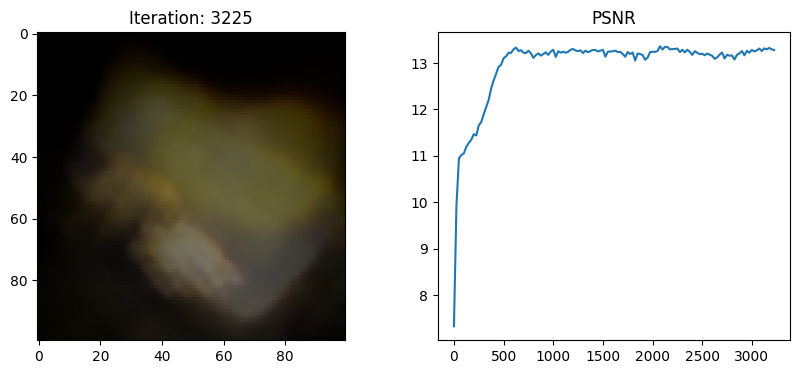

3250 0.05017290115356445 secs per iter


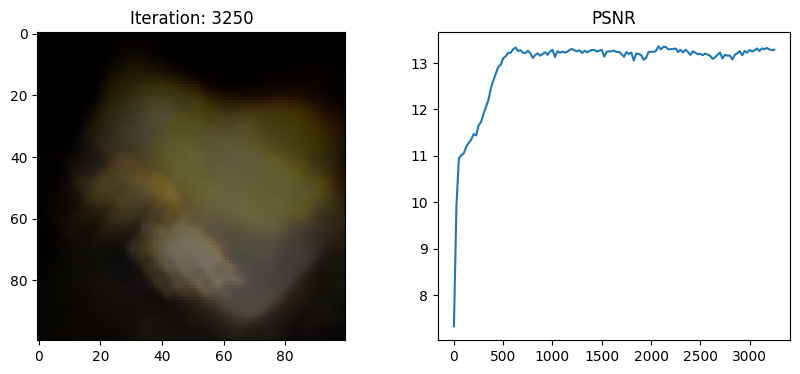

3275 0.05598552703857422 secs per iter


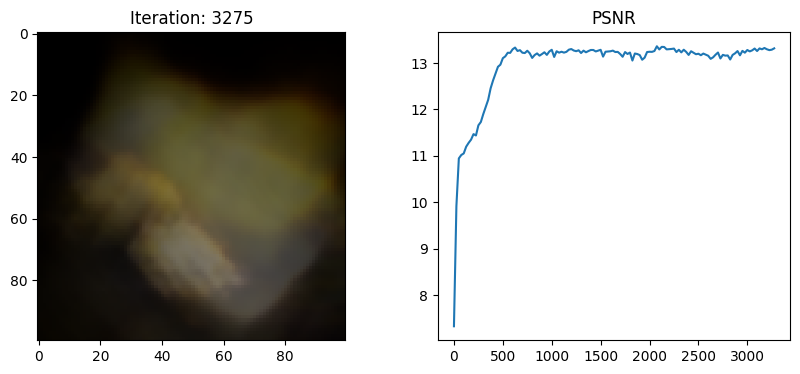

3300 0.05472667694091797 secs per iter


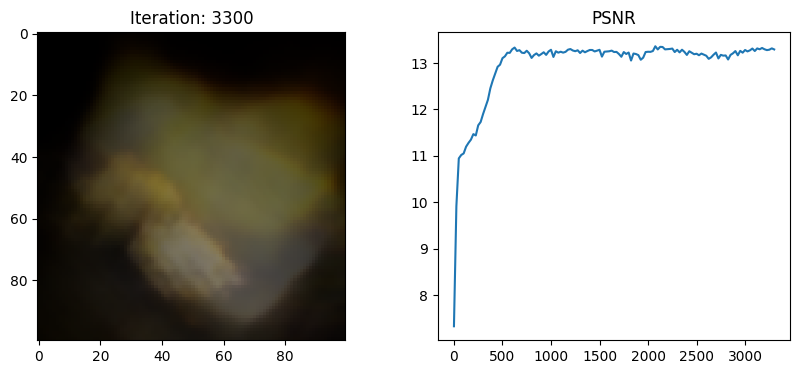

3325 0.05023056030273437 secs per iter


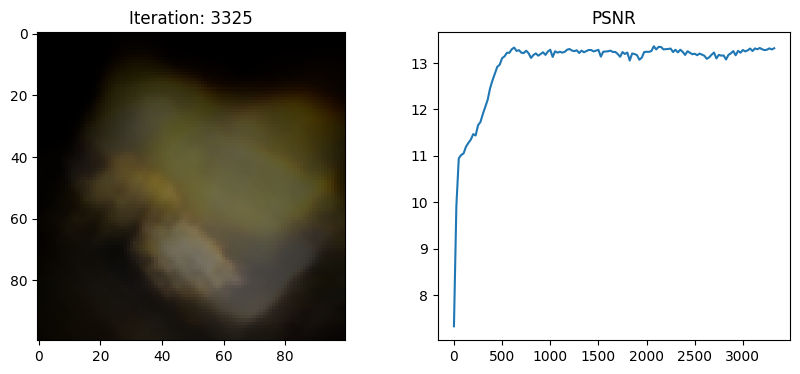

3350 0.050304832458496096 secs per iter


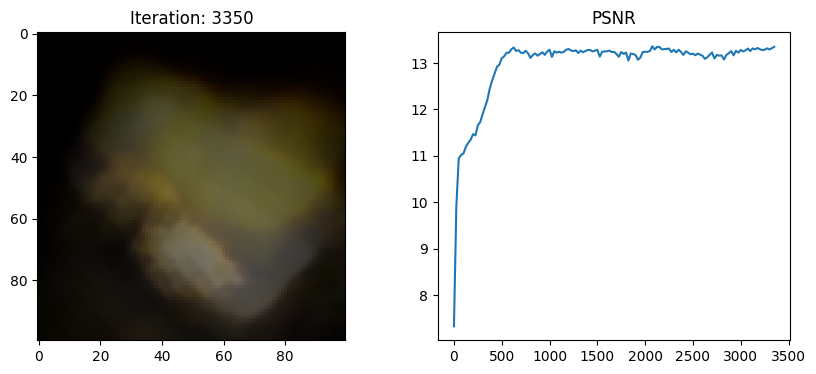

3375 0.05067002296447754 secs per iter


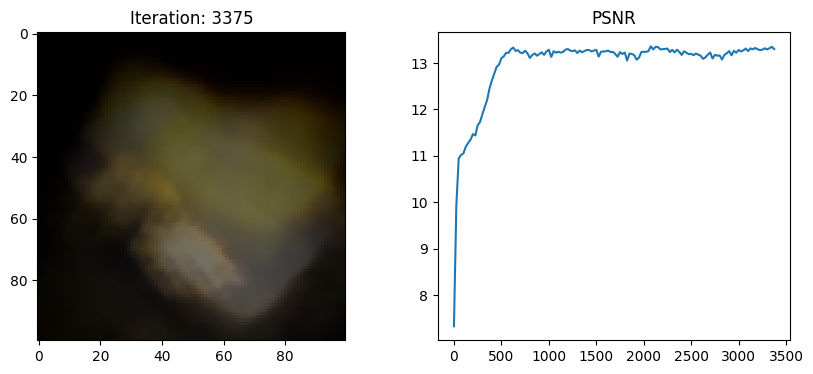

3400 0.05096378326416016 secs per iter


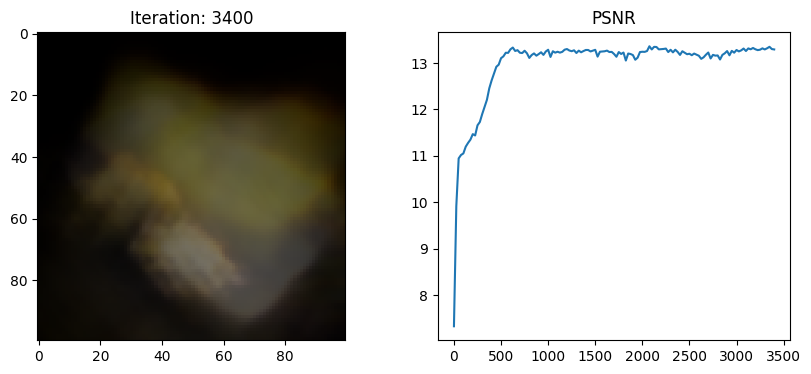

3425 0.050716733932495116 secs per iter


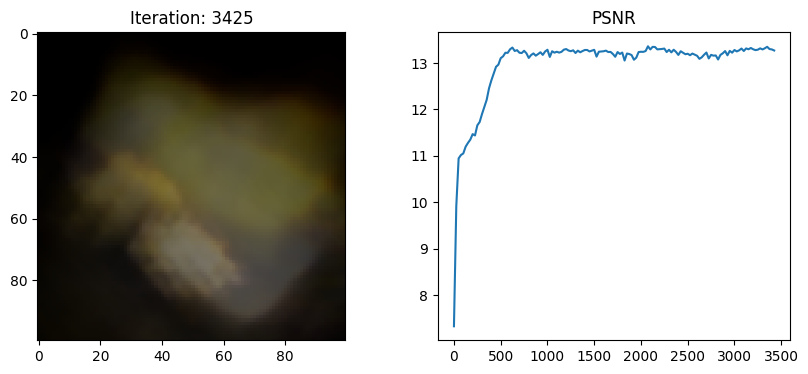

3450 0.05710310935974121 secs per iter


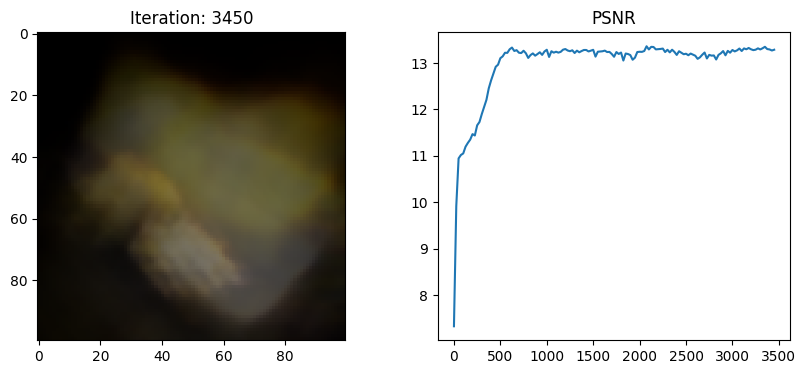

3475 0.05207973480224609 secs per iter


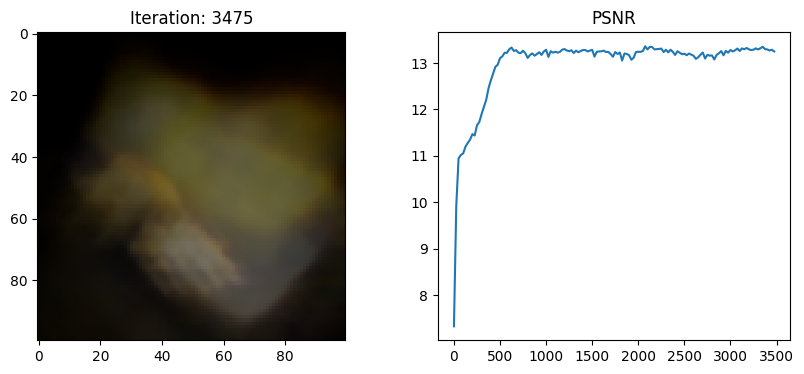

3500 0.057757997512817384 secs per iter


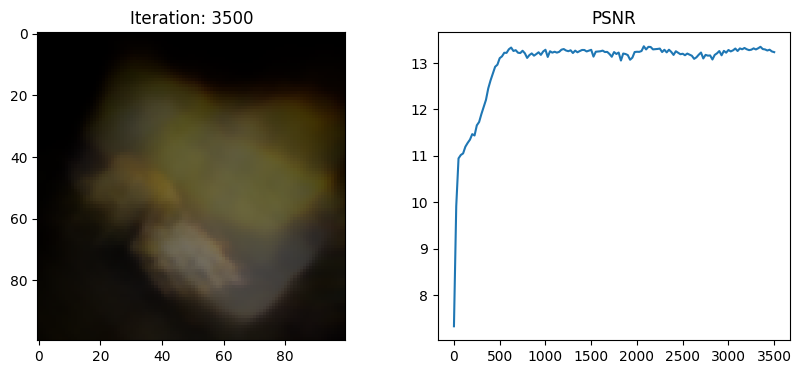

3525 0.05844773292541504 secs per iter


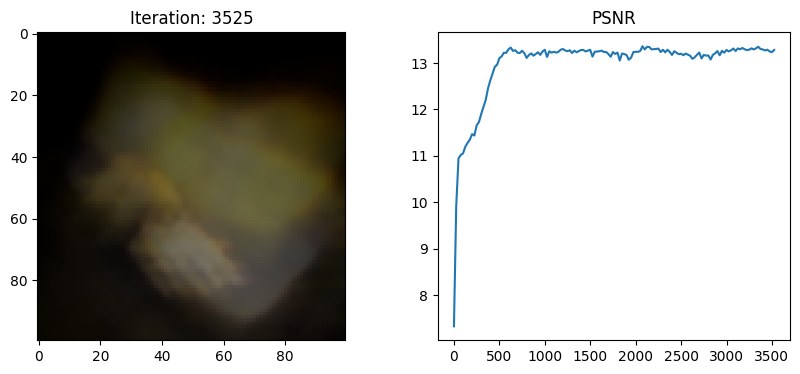

3550 0.051026134490966796 secs per iter


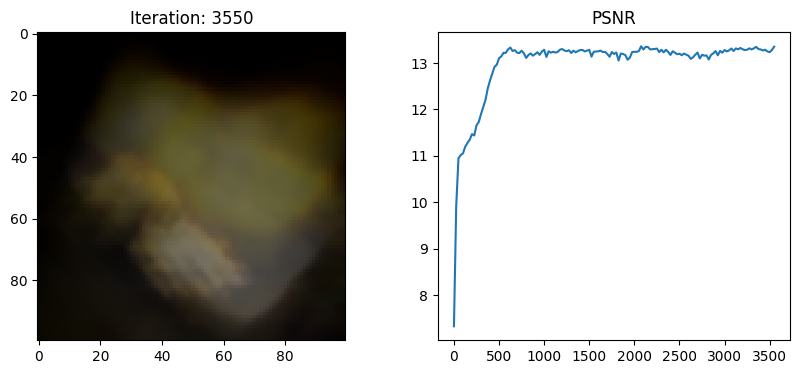

3575 0.05094319343566894 secs per iter


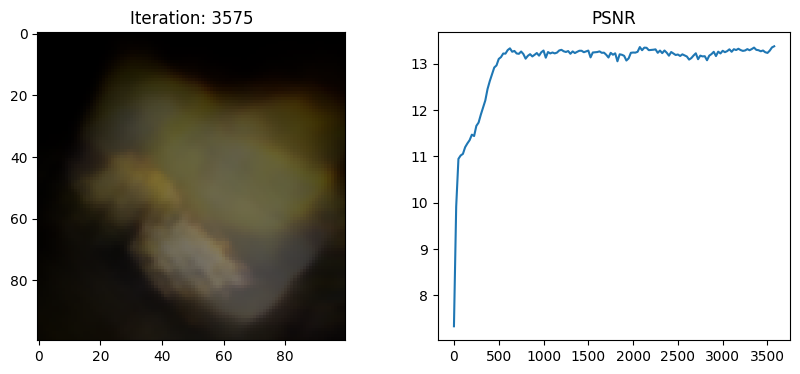

3600 0.05100107192993164 secs per iter


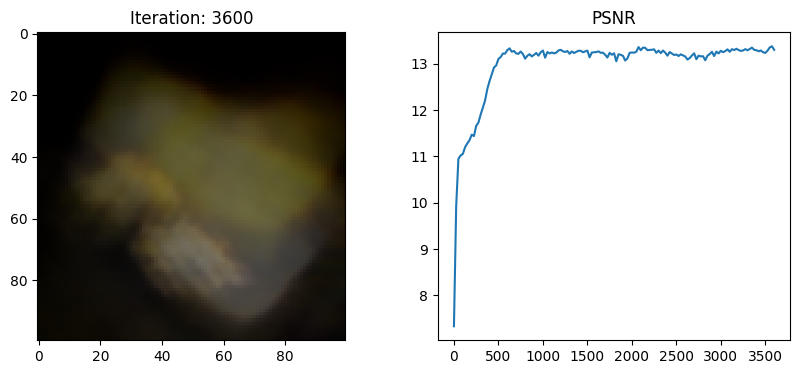

3625 0.0500499153137207 secs per iter


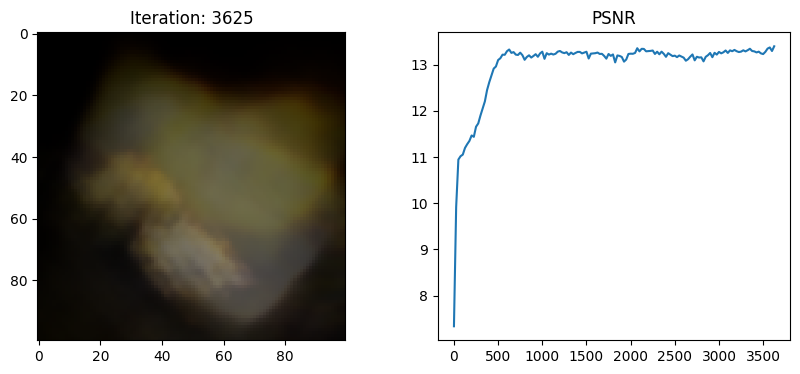

3650 0.05052042961120606 secs per iter


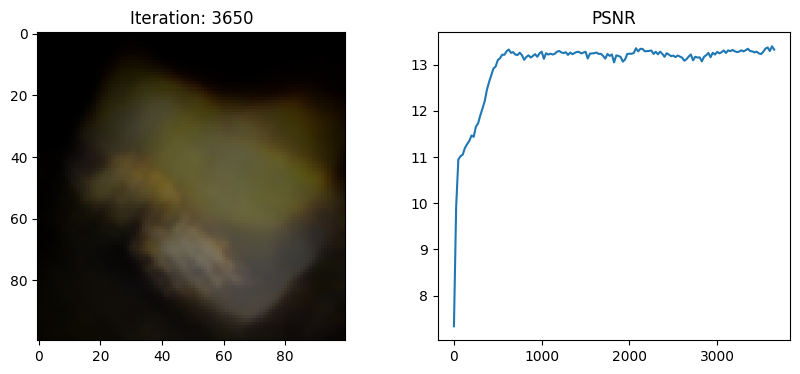

3675 0.04962593078613281 secs per iter


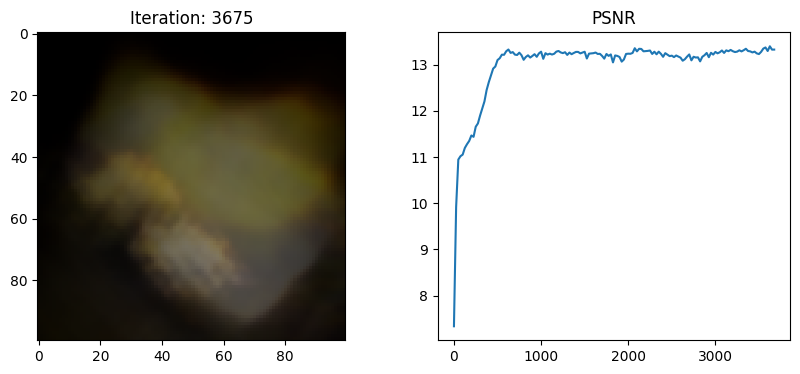

3700 0.050330400466918945 secs per iter


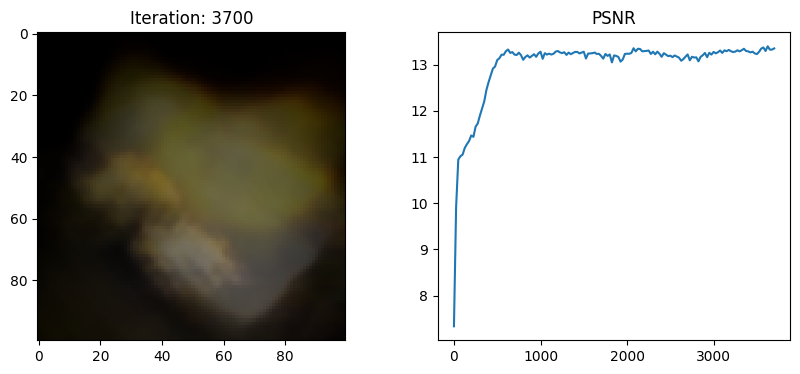

3725 0.05049046516418457 secs per iter


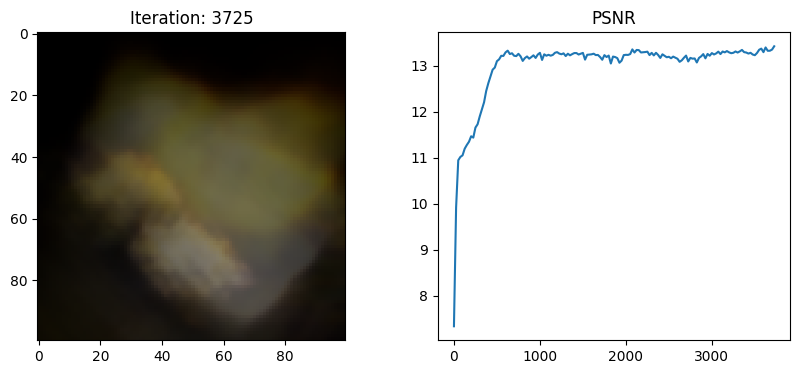

3750 0.05663914680480957 secs per iter


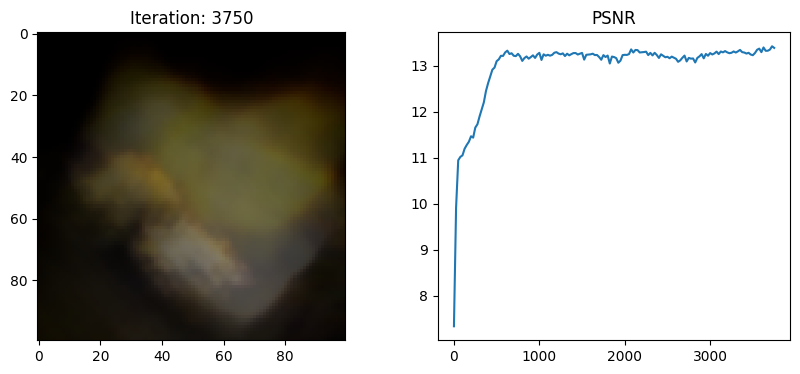

3775 0.04967818260192871 secs per iter


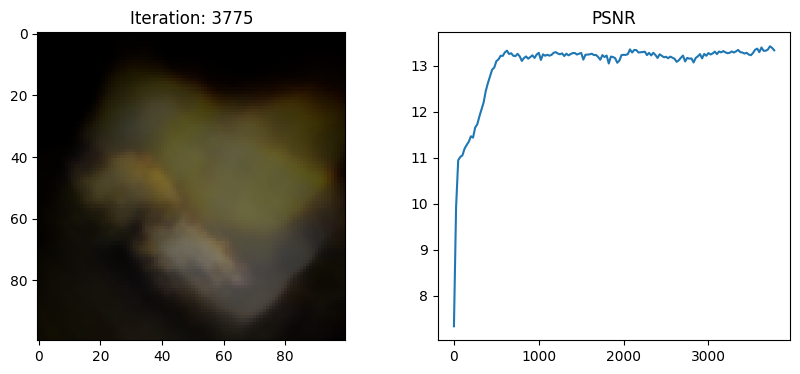

3800 0.057499208450317384 secs per iter


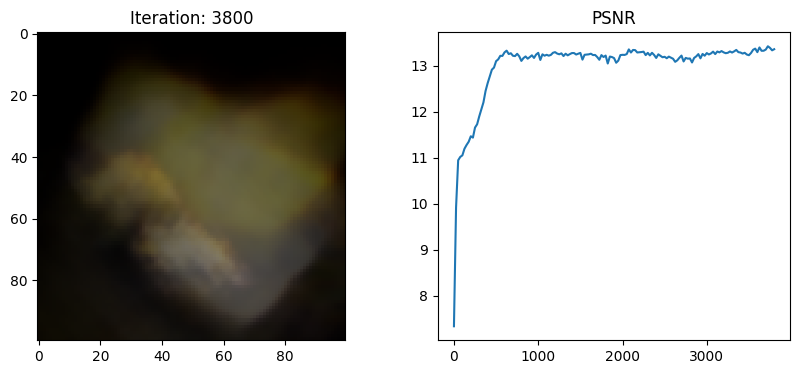

3825 0.050304021835327145 secs per iter


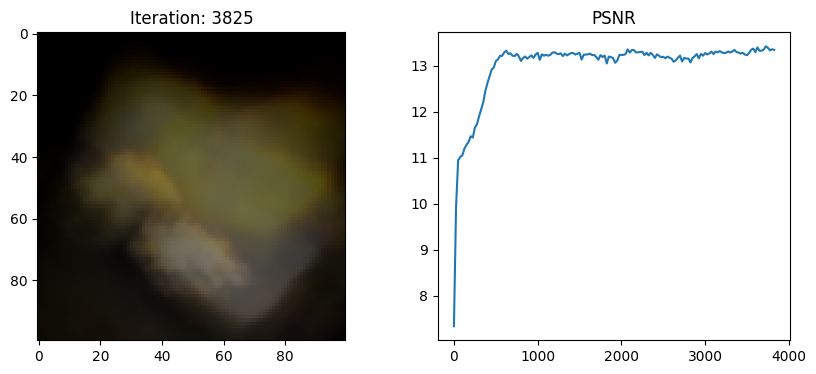

3850 0.05166029930114746 secs per iter


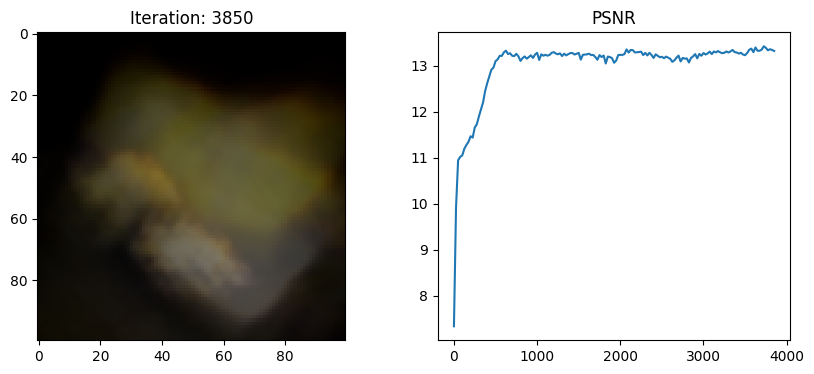

3875 0.05065901756286621 secs per iter


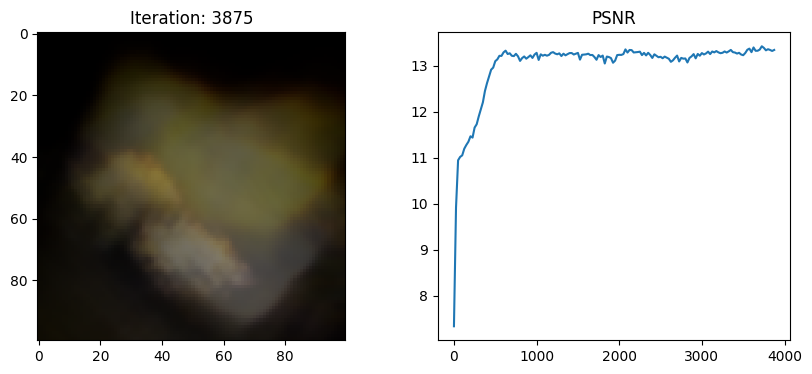

3900 0.04989885330200195 secs per iter


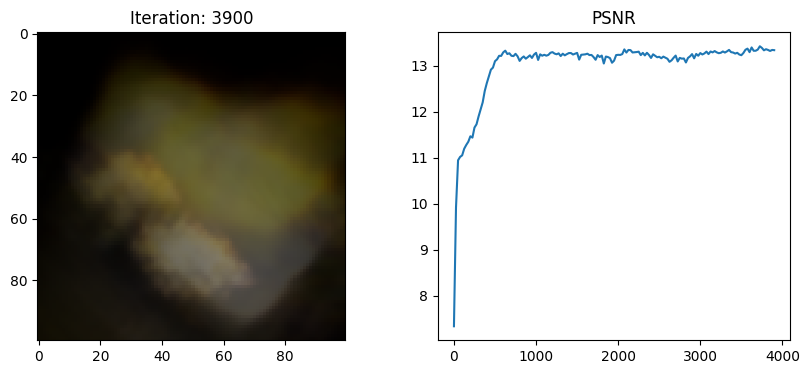

3925 0.04987272262573242 secs per iter


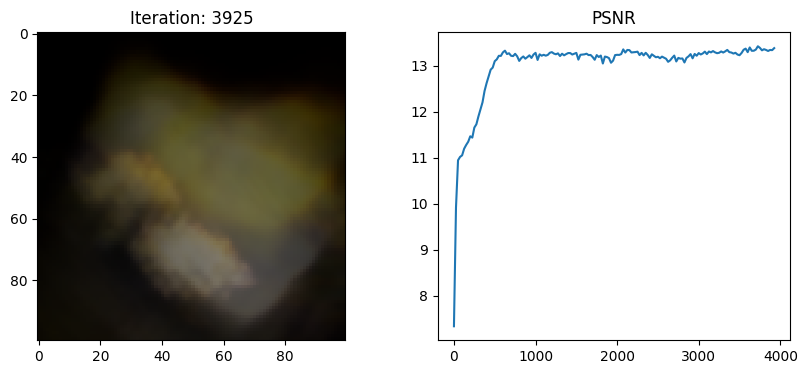

3950 0.05000931739807129 secs per iter


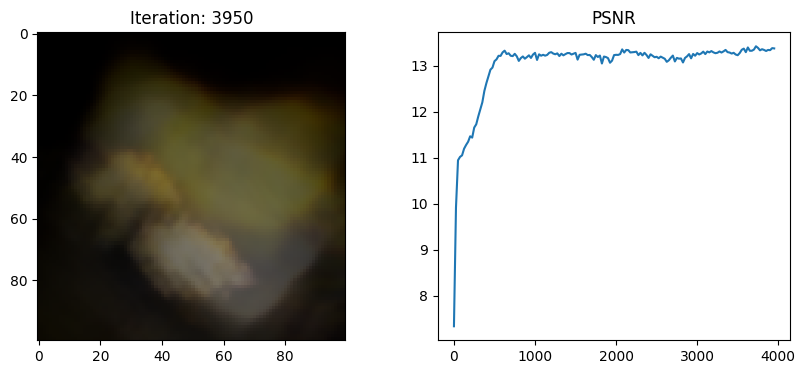

3975 0.053822841644287106 secs per iter


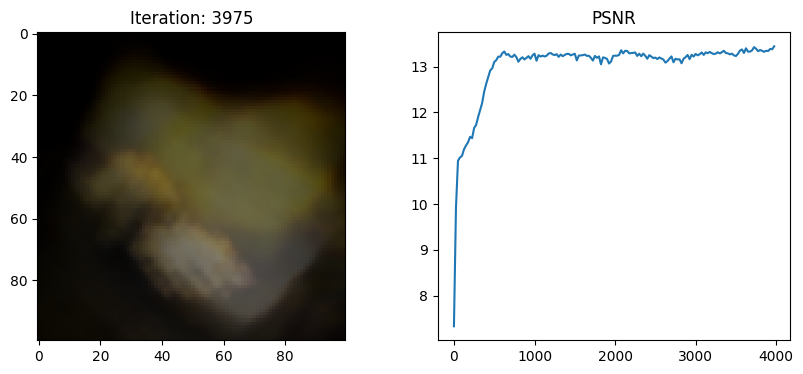

4000 0.05601095199584961 secs per iter


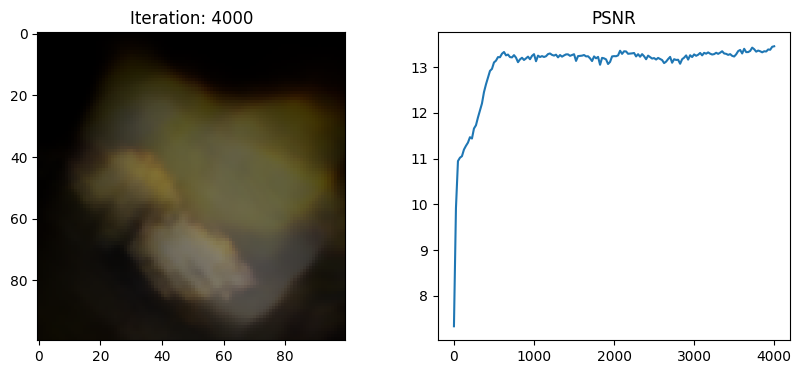

Done


In [7]:
N_iters = 4000
psnrs = []
iternums = []
i_plot = 25
loss_f = torch.nn.MSELoss()
load_model = False
true_NeRF = False
chunksize = 2**15


if not true_NeRF:
    ### Light model if on colab or on cpu (cpu is not recommended unless you have a lot of time)
    N_samples = 32
    N_samples_hierarchical = 32
    model = full_NeRF(2.0, 6.0, pos_embed=6, useViewDirs=False, useHierarchicalSampling=True, chunksize=chunksize, D_coarse=2, skip_coarse=[], D_fine=6, skip_fine=[3], W_coarse=128, W_fine=128, rand_stratified_sampling=False).to(device)
else:
    if device == 'cpu' or IN_COLAB:
        print("Warning: using full NeRF architecture on cpu or colab is not recommended. Set true_NeRF to False.")
    ### True NeRF model for strong GPUs
    N_samples = 64
    N_samples_hierarchical = 128
    model = full_NeRF(2.0, 6.0).to(device)

lr = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


if load_model:
    model.load_state_dict(torch.load('tiny_nerf_extended_trained.pt', map_location=device))
    model.eval()
    print('Model loaded')
else:
    print('Training model')
    import time
    t = time.time()
    for i in range(N_iters+1):
        model.train()
        img_i = np.random.randint(images.shape[0])
        target = images[img_i]
        pose = poses[img_i]
        height, width = target.shape[:2]
        target = torch.from_numpy(target).to(device)
        rays_o, rays_d = get_rays(H, W, focal, pose)
        rays_o = rays_o.reshape(-1,3)
        rays_d = rays_d.reshape(-1,3)

        optimizer.zero_grad()
        rgb = model(rays_o, rays_d)
        rgb = rgb.reshape([height, width, 3])
        loss = loss_f(rgb, target)
        loss.backward()
        optimizer.step()
        del loss, rgb, target, rays_o, rays_d

        if i%i_plot==0:
            model.eval()
            print(i, (time.time() - t) / i_plot, 'secs per iter')
            t = time.time()

            # Render the holdout view for logging
            rays_o, rays_d = get_rays(H, W, focal, testpose)
            rays_o = rays_o.reshape(-1,3)
            rays_d = rays_d.reshape(-1,3)
            rgb = model(rays_o, rays_d)
            rgb = rgb.reshape([height, width, 3])
            loss = loss_f(rgb, torch.from_numpy(testimg).to(device))
            psnr = -10. * np.log10(loss.item())

            psnrs.append(psnr)
            iternums.append(i)

            plt.figure(figsize=(10,4))
            plt.subplot(121)
            plt.imshow(rgb.cpu().detach().numpy())
            plt.title(f'Iteration: {i}')
            plt.subplot(122)
            plt.plot(iternums, psnrs)
            plt.title('PSNR')
            plt.show()
            del rgb, loss, psnr, rays_o, rays_d

    print('Done')
    #save model
    torch.save(model.state_dict(), 'tiny_nerf_extended_trained.pt')